In [58]:
%reset -fs

In [59]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [60]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

import tensorflow as tf
import os

from keras.models import Model, Sequential
from keras.layers import LSTM, Input, BatchNormalization, Conv2D, Conv1D, Dense, MaxPooling2D, MaxPooling1D, Flatten, Dropout, InputLayer, SimpleRNN, TimeDistributed
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing import image
from sklearn.preprocessing import scale, minmax_scale
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [61]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
clip_length = 29
sr = 22050

First, we need to load in the music. Librosa takes the .wav file and gives you a vector to represent it, plus a sample rate.

In [62]:
filename = 'classical.00000.wav'
y, sr = librosa.load('Data/genres_original/' + genres[1] + '/' + filename)

print(f'File name: {filename}')
print(f'y: {y}')
print(f'Vector shape: {y.shape}')
print(f'Sample rate: {sr}')

File name: classical.00000.wav
y: [-0.02008057 -0.01748657  0.00418091 ...  0.01934814  0.027771
  0.03131104]
Vector shape: (661794,)
Sample rate: 22050


In [63]:
y = y[:sr * clip_length] # Ensuring that each clip ends up being the same length

The below is a Fourier transform, taking the 1D vector we have and making one that is 2D.

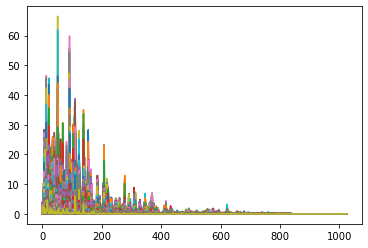

In [64]:
D = np.abs(librosa.stft(y))
plt.plot(D);

Next, we are converting that 2D vector into a spectograph, which has time along the X axis and frequencies on the Y axis. This gives us the contour of the music. It looks like it has a vertical pattern. because each pitch has overtones that manifest at higher frequencies.

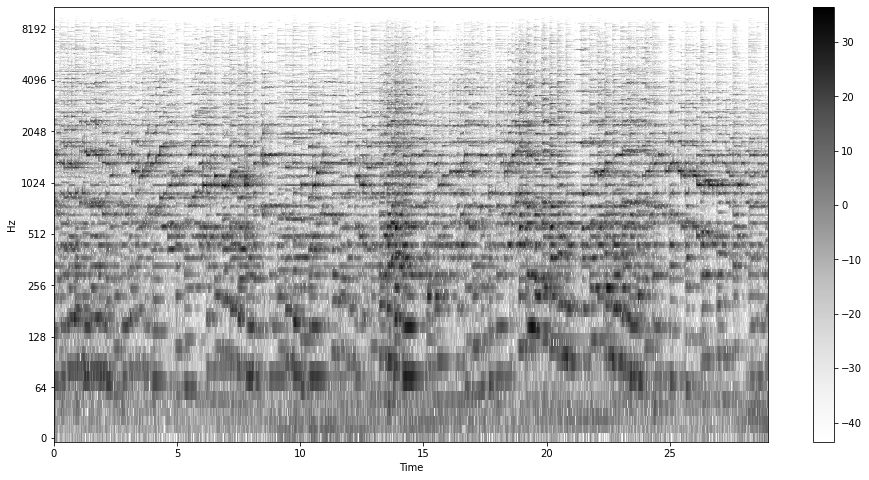

In [65]:
DB = librosa.amplitude_to_db(D)
plt.figure(figsize = (16,8))
librosa.display.specshow(DB, sr = sr, x_axis = 'time', y_axis = 'log', cmap = 'Greys')
plt.colorbar()

Same graph, but colorized.

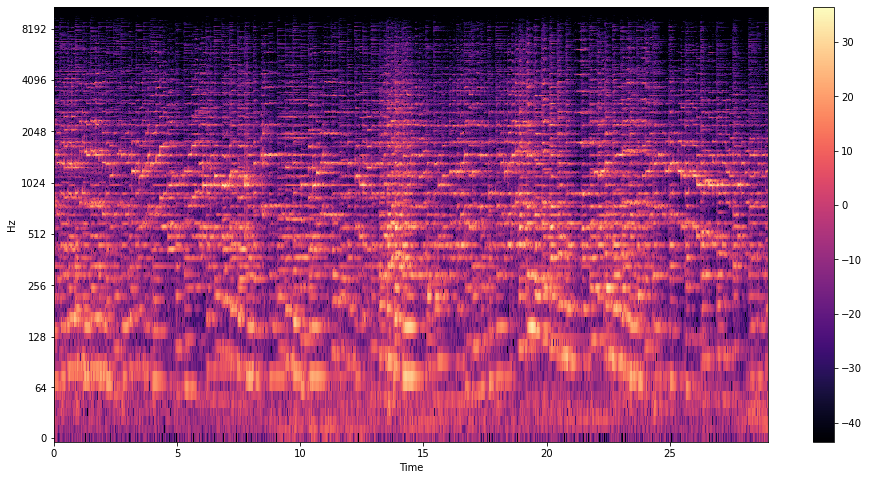

In [66]:
plt.figure(figsize = (16,8))
librosa.display.specshow(DB, sr = sr, x_axis = 'time', y_axis = 'log', cmap = 'magma')
plt.colorbar()

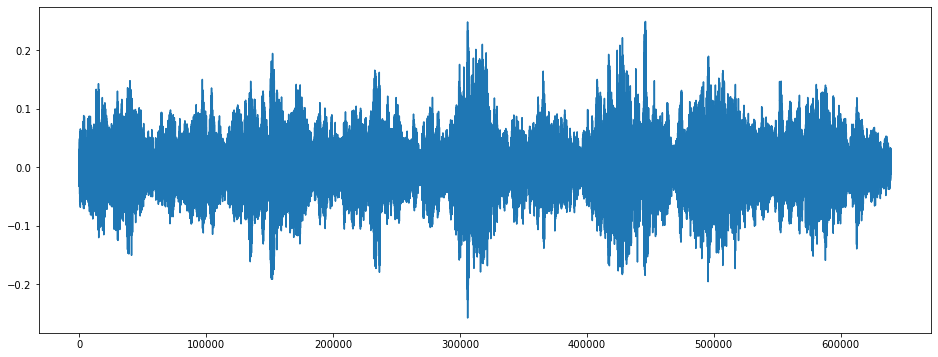

In [67]:
y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize = (16, 6))
plt.plot(y_harm);

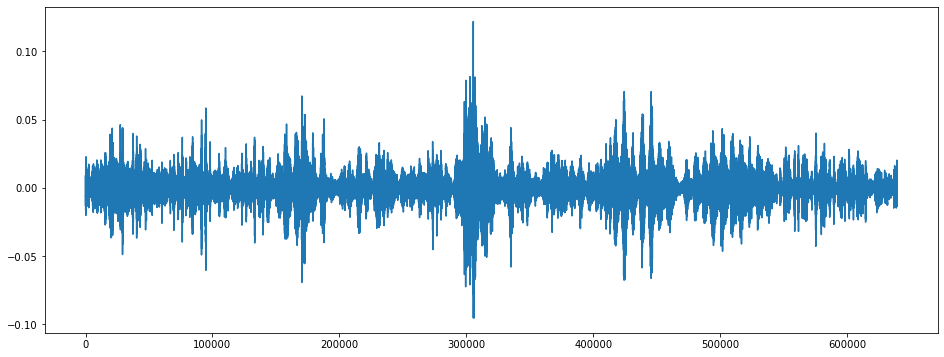

In [68]:
plt.figure(figsize = (16, 6))
plt.plot(y_perc);


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1221620906.py:2: FutureWarning: Pass y=[-0.02008057 -0.01748657  0.00418091 ... -0.00320435 -0.00531006
 -0.00732422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(y)[0]


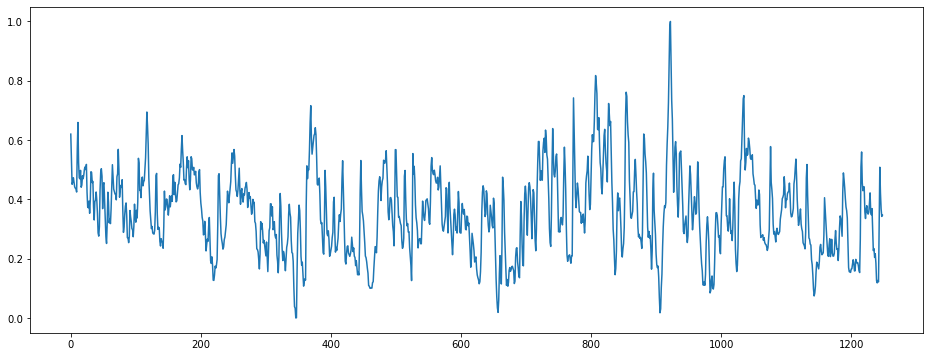

In [69]:
plt.figure(figsize = (16, 6))
spectral_centroids = librosa.feature.spectral_centroid(y)[0]
plt.plot(minmax_scale(spectral_centroids));



/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/880563799.py:2: FutureWarning: Pass y=[-0.02008057 -0.01748657  0.00418091 ... -0.00320435 -0.00531006
 -0.00732422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(y)
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


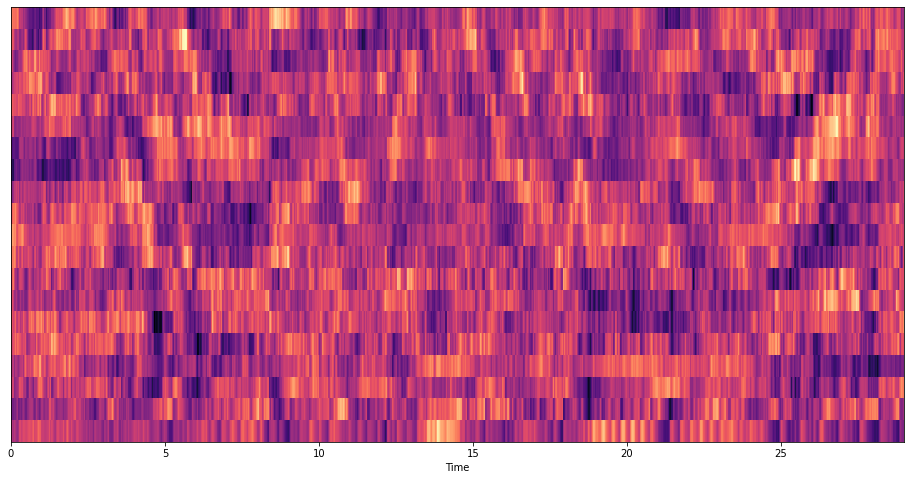

In [70]:
plt.figure(figsize = (16, 8))
mfccs = librosa.feature.mfcc(y)
mfccs = scale(mfccs, axis=1)
librosa.display.specshow(mfccs, x_axis='time', cmap = 'magma');



/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1218125955.py:2: FutureWarning: Pass y=[-0.02008057 -0.01748657  0.00418091 ... -0.00320435 -0.00531006
 -0.00732422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chromagram = librosa.feature.chroma_stft(y)


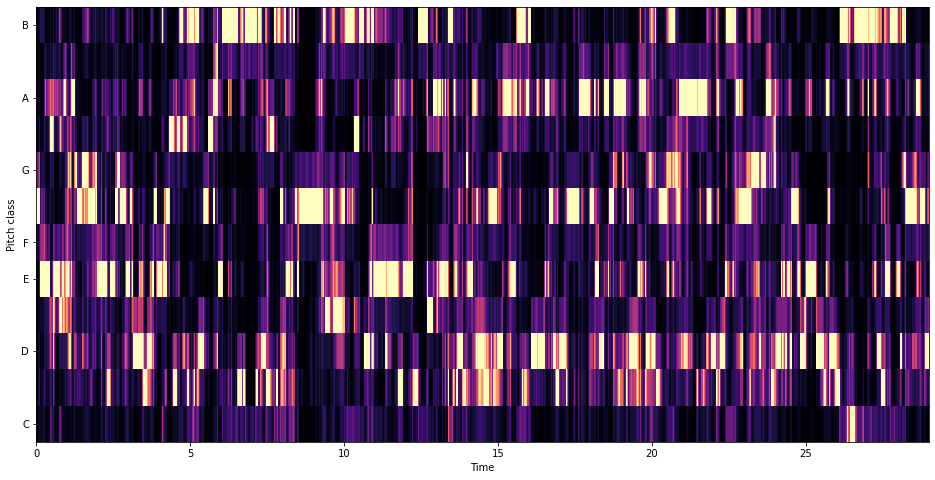

In [71]:
plt.figure(figsize = (16, 8))
chromagram = librosa.feature.chroma_stft(y)
librosa.display.specshow(chromagram, x_axis='time', y_axis = 'chroma', cmap = 'magma');



All right, time to take these visuals and put them into a neural network to see if these genres can be learned.

data_dict = {'fourier':,           # 2D
             'spectograph':0,       # 2D
             'harmony':,           # 1D
             'percussion':1,        # 1D
             'spectral_centroid':, # 1D
             'mfcc':2,              # 2D
             'chromagram':3}        # 2D

In [72]:
data_path = 'Data/genres_original'
def get_data(data_directory):
    data = []
    genre_list = []
    for i, genre in enumerate(genres): # Go through each genre folder and convert each file to a vector
        path = data_path + '/' + genre
        files = os.listdir(path)
        for file in files:
            if file == '.DS_Store':
                break
            print("Processing " + file)
            path_file = path + '/' + file
            wav_arr, sr = librosa.load(path_file)
            wav_arr = wav_arr[:sr * clip_length] # Clipping to make sure each file is the same length
            D = np.abs(librosa.stft(wav_arr)) # Fourier transform
            DB = librosa.amplitude_to_db(D, ref = np.max) # Spectograph
            #S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
            #S_DB = librosa.amplitude_to_db(S, ref=np.max)
            harm, perc = librosa.effects.hpss(wav_arr) # Harmony, Percussion
            
            
            # spectral_centroids = librosa.feature.spectral_centroid(wav_arr, sr=sr)[0] # Spectral centroid
            
            mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
            mfccs = scale(mfccs, axis=1)
            chromagram = librosa.feature.chroma_stft(wav_arr) # Chromagram
            
            data.append([DB, perc, mfccs, chromagram])
            genre_list.append(i)
            pass
        pass
    return np.array(data), np.array(genre_list)

In [73]:
X, y = get_data(data_path) # Taking the genre (eg. 'blues') and turning it into an index (0)
label_dict = {}
for i, label in enumerate(genres):
    label_dict[i] = label

Processing blues.00093.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[0.04281616 0.06796265 0.06079102 ... 0.01293945 0.00924683 0.00668335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.04281616 0.06796265 0.06079102 ... 0.01293945 0.00924683 0.00668335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(

Processing blues.00087.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.36514282  0.5903015   0.5239563  ... -0.02044678  0.01052856
  0.02294922] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00050.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06652832  0.09335327  0.04510498 ... -0.15512085  0.05050659
  0.12200928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00044.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.11239624  0.14764404  0.11526489 ... -0.13101196 -0.08322144
 -0.04125977] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00078.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.15414429 0.1751709  0.0730896  ... 0.38946533 0.2709961  0.25964355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00079.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.236969   -0.296875   -0.08099365 ...  0.11444092  0.18371582
  0.17532349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00045.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.01901245 -0.04046631 -0.05606079 ... -0.05960083 -0.08462524
 -0.06381226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01901245 -0.04046631 -0.05606079 ... -0.05960083 -0.08462524
 -0.06381226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing blues.00051.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.21359253 -0.35723877 -0.31430054 ... -0.5350342  -0.5721741
 -0.6218872 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.21359253 -0.35723877 -0.31430054 ... -0.5350342  -0.5721741
 -0.6218872 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  wa

Processing blues.00086.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05612183 -0.13653564 -0.17175293 ...  0.24429321  0.26779175
  0.2996521 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00092.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.09863281  0.15170288  0.12884521 ... -0.14974976 -0.14974976
 -0.14331055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00084.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00338745  0.15115356  0.18841553 ...  0.04580688 -0.05221558
 -0.17324829] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00090.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03161621  0.05133057  0.0489502  ... -0.25668335 -0.25164795
 -0.25506592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00047.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10806274 -0.15075684 -0.17327881 ... -0.11196899 -0.11248779
 -0.08221436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00053.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.19836426 -0.38546753 -0.2819519  ...  0.1295166   0.1711731
  0.15969849] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing blues.00052.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01705933  0.03436279  0.03353882 ... -0.0255127  -0.04318237
 -0.05886841] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00046.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01647949  0.03048706  0.01889038 ... -0.05316162 -0.03231812
 -0.01223755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00091.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04489136  0.07424927  0.06942749 ... -0.01644897 -0.01864624
 -0.02377319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00085.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02090454  0.01016235  0.04364014 ...  0.14450073  0.14874268
  0.15789795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00081.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13650513 -0.23358154 -0.21896362 ...  0.01101685  0.01208496
  0.01785278] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00095.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00396729  0.00012207  0.0166626  ...  0.00119019 -0.05181885
 -0.10803223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00042.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.03710938 0.07446289 0.07992554 ... 0.07937622 0.05682373 0.08413696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00056.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1638794  -0.28948975 -0.26593018 ...  0.18869019  0.21936035
  0.20831299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00057.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00799561 0.0022583  0.01434326 ... 0.2447815  0.26208496 0.1430664 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00043.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1104126  -0.16241455 -0.11431885 ...  0.00305176  0.00106812
 -0.0012207 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00094.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16357422 -0.18377686 -0.14898682 ... -0.2029419  -0.20062256
 -0.1975708 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00080.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.23739624 0.36120605 0.30667114 ... 0.02130127 0.06884766 0.02450562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00096.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00015259  0.00466919  0.01028442 ... -0.00280762  0.00302124
  0.00939941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00082.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.25909424  0.48797607  0.5100403  ... -0.2939453  -0.2470398
 -0.22979736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing blues.00069.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06060791 0.08435059 0.06304932 ... 0.00061035 0.04797363 0.00439453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00055.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00479126 0.05578613 0.12127686 ... 0.19360352 0.18237305 0.18167114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00041.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03082275 -0.03540039 -0.03076172 ...  0.0039978   0.04190063
  0.02893066] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00040.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0980835  -0.08453369 -0.06008911 ... -0.22927856 -0.22720337
 -0.14743042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00054.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14169312 -0.22286987 -0.19650269 ... -0.08560181 -0.16381836
 -0.2524109 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00068.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02215576 -0.02536011 -0.0512085  ...  0.08178711  0.05114746
  0.08950806] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00083.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0244751  -0.0541687  -0.08081055 ... -0.40618896 -0.42492676
 -0.3874817 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00097.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06954956 0.11352539 0.10494995 ... 0.06845093 0.15917969 0.24963379] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00033.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00836182 -0.01040649 -0.01641846 ...  0.1791687   0.1855774
  0.18960571] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing blues.00027.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.02020264 -0.03634644 -0.02706909 ...  0.31549072  0.25512695
  0.11700439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02020264 -0.03634644 -0.02706909 ...  0.31549072  0.25512695
  0.11700439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing blues.00026.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03570557  0.05581665  0.04812622 ... -0.0222168  -0.02233887
 -0.02142334] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00032.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10046387 -0.15109253 -0.15005493 ...  0.28598022  0.30718994
  0.34301758] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00024.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.0005188   0.00067139 -0.00146484 ...  0.02685547  0.0328064
  0.03793335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0005188   0.00067139 -0.00146484 ...  0.02685547  0.0328064
  0.03793335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  wa

Processing blues.00030.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.0552063   0.08731079  0.07107544 ... -0.14727783 -0.17416382
 -0.2133789 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0552063   0.08731079  0.07107544 ... -0.14727783 -0.17416382
 -0.2133789 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing blues.00018.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.10031128 -0.1550293  -0.12982178 ...  0.06454468  0.08084106
  0.09976196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10031128 -0.1550293  -0.12982178 ...  0.06454468  0.08084106
  0.09976196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing blues.00019.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10144043  0.16815186  0.14266968 ... -0.05255127 -0.05413818
 -0.04037476] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00031.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00354004  0.00198364 -0.01864624 ...  0.0604248   0.07241821
  0.07473755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00025.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03338623 -0.05020142 -0.03128052 ... -0.02023315 -0.0272522
 -0.02877808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing blues.00009.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.04647827 0.06399536 0.04327393 ... 0.00296021 0.01040649 0.00811768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00021.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04711914  0.07504272  0.06588745 ... -0.06063843 -0.04718018
 -0.03494263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00035.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03277588 -0.04876709 -0.04104614 ...  0.308136    0.2911377
  0.32910156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing blues.00034.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01361084  0.02810669  0.03515625 ... -0.05291748 -0.03845215
 -0.03094482] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00020.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03634644 -0.05361938 -0.04153442 ...  0.02276611  0.02233887
  0.02392578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00008.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01138306  0.02175903  0.0100708  ... -0.1638794  -0.11468506
 -0.08145142] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00036.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.17077637 -0.27716064 -0.26010132 ...  0.5637512   0.56521606
  0.5651245 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00022.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07327271 -0.1105957  -0.10214233 ... -0.03295898 -0.05532837
 -0.08590698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00023.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.17184448  0.20730591  0.08227539 ... -0.02206421 -0.02053833
 -0.02191162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00037.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0017395   0.00390625  0.00375366 ... -0.01898193 -0.02429199
 -0.02102661] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00012.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.1854248   0.24972534  0.15673828 ... -0.05099487 -0.03005981
  0.0050354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00006.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.1822815   0.28302002  0.21020508 ... -0.04260254 -0.08804321
 -0.1940918 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00007.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01290894  0.00811768 -0.00445557 ...  0.05151367  0.03869629
  0.02920532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00013.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13864136 -0.20974731 -0.1781311  ...  0.02374268  0.04931641
  0.07818604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00005.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02429199 -0.02975464 -0.00961304 ...  0.01119995  0.01870728
  0.02920532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00011.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02560425 -0.03881836 -0.03527832 ...  0.09512329  0.07717896
  0.05621338] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00039.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01055908 -0.01623535 -0.012146   ... -0.01156616 -0.00985718
 -0.00793457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01089478 -0.01052856 -0.00549316 ... -0.21209717 -0.3204956
 -0.39593506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing blues.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.12014771  0.14956665  0.10458374 ... -0.09701538 -0.08981323
 -0.0586853 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00631714 -0.00927734 -0.0083313  ... -0.20944214 -0.20883179
 -0.17141724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.23886108 -0.41534424 -0.3161621  ... -0.0012207  -0.00149536
 -0.00280762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00732422  0.01660156  0.00762939 ... -0.15670776 -0.14892578
 -0.13076782] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.07705688  0.11590576  0.09234619 ...  0.02520752 -0.00372314
 -0.03240967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03015137 -0.0453186  -0.04034424 ... -0.12677002 -0.13269043
 -0.11834717] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00341797  0.00430298  0.00137329 ... -0.1506958  -0.13311768
 -0.09832764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01669312 -0.02764893 -0.02191162 ...  0.10186768  0.105896
  0.10617065] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyke

Processing blues.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02462769  0.03604126  0.02981567 ... -0.0328064  -0.03411865
 -0.03683472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01300049 -0.03060913 -0.03607178 ...  0.04470825  0.04400635
  0.04241943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.01901245 0.04769897 0.02941895 ... 0.11923218 0.12179565 0.09854126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02941895 -0.02072144  0.00424194 ... -0.23138428 -0.1192627
  0.02331543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing blues.00071.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02502441 -0.15545654 -0.22753906 ... -0.09481812 -0.17114258
 -0.21994019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00065.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06378174  0.08837891  0.04940796 ... -0.07025146 -0.05337524
  0.01669312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00059.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00588989  0.00765991  0.0012207  ... -0.25698853 -0.29562378
 -0.30142212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00058.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.12524414 0.18426514 0.09741211 ... 0.07989502 0.0501709  0.0267334 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00064.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02407837 -0.05328369 -0.06829834 ...  0.07092285  0.06869507
  0.12988281] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00070.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03820801 -0.06240845 -0.06326294 ...  0.0368042   0.03390503
  0.03393555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00099.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00332642 -0.01135254 -0.00799561 ...  0.0296936   0.03338623
  0.03604126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00066.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.07894897 0.13638306 0.13336182 ... 0.06607056 0.04141235 0.03988647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00072.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.04190063 0.11297607 0.15304565 ... 0.169281   0.15063477 0.11264038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00073.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13711548 -0.23635864 -0.2230835  ...  0.14675903  0.19763184
  0.19033813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00067.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04641724 -0.12106323 -0.13388062 ... -0.13198853 -0.15939331
 -0.15765381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00098.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.17141724  0.23706055  0.10256958 ... -0.1331482  -0.06872559
  0.03686523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00088.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00299072  0.00485229  0.00845337 ...  0.26867676  0.28302002
  0.29089355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00063.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13821411 -0.22592163 -0.18408203 ... -0.15252686 -0.21911621
 -0.17016602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00077.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07684326 -0.13812256 -0.118927   ...  0.47860718  0.52667236
  0.46987915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00076.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.24917603 -0.32904053 -0.15524292 ...  0.10934448  0.06735229
  0.06427002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00062.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06283569 0.08822632 0.08084106 ... 0.13381958 0.12893677 0.1434021 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing blues.00089.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.23117065  0.3553772   0.30532837 ... -0.06359863 -0.05740356
 -0.05563354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00048.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.21246338  0.31881714  0.17388916 ... -0.03369141 -0.06643677
 -0.0916748 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00074.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.131073   -0.11239624 -0.02319336 ... -0.4716797  -0.5628967
 -0.5222473 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing blues.00060.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.16952515  0.29315186  0.1512146  ...  0.0038147   0.01687622
 -0.00933838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00061.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16659546 -0.23223877 -0.2239685  ... -0.13479614 -0.14990234
  0.05636597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00075.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.5245056  -0.81640625 -0.5826111  ...  0.00588989  0.00549316
 -0.00369263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing blues.00049.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04974365 -0.08596802 -0.08615112 ... -0.00708008 -0.00579834
 -0.00366211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00079.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01782227 -0.01669312 -0.01486206 ... -0.00152588 -0.00152588
 -0.00131226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00045.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06307983 -0.05401611 -0.04678345 ...  0.00592041  0.0637207
  0.10626221] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00051.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00204468 -0.00216675 -0.00149536 ...  0.18969727  0.14193726
  0.09115601] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00086.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01403809 -0.01486206 -0.01907349 ...  0.01504517  0.01153564
  0.00759888] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00092.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02633667  0.04815674  0.05267334 ... -0.10229492 -0.1385498
 -0.14376831] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00093.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07272339 -0.12576294 -0.11993408 ...  0.00314331  0.06564331
  0.12493896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00087.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01074219  0.01446533  0.01654053 ... -0.03686523 -0.02853394
 -0.02523804] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00050.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00305176  0.00137329  0.00415039 ... -0.009552   -0.00665283
 -0.00393677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00044.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01296997  0.01077271  0.0088501  ... -0.00891113 -0.00802612
 -0.00686646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00078.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00167847 0.00262451 0.00344849 ... 0.00021362 0.00024414 0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00052.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06484985 -0.10720825 -0.10943604 ...  0.0088501   0.00653076
 -0.00012207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00046.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06967163  0.06594849  0.04238892 ... -0.19702148 -0.190094
 -0.13360596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyke

Processing classical.00091.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00039673  0.01599121  0.02667236 ... -0.13058472 -0.10452271
 -0.08578491] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00085.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00100708  0.00228882  0.00390625 ... -0.00238037 -0.0105896
 -0.02102661] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00084.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03964233 -0.03643799 -0.03091431 ...  0.01882935  0.0328064
  0.04806519] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00090.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02862549  0.01321411 -0.02185059 ... -0.02944946 -0.01480103
 -0.00512695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00047.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00784302  0.00726318  0.00582886 ... -0.00805664 -0.00827026
 -0.00735474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00053.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.20825195 -0.16204834 -0.12033081 ... -0.10406494 -0.10964966
 -0.09054565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00057.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01312256 -0.01367188 -0.01391602 ... -0.02249146 -0.01937866
 -0.01815796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00043.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05654907  0.04812622  0.03131104 ... -0.00970459 -0.02728271
 -0.0506897 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00094.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00534058  0.00323486 -0.00183105 ... -0.01498413 -0.0145874
 -0.01153564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00080.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04049683 -0.0402832  -0.0397644  ...  0.00531006  0.00469971
  0.0038147 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00081.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03338623 -0.02575684 -0.0166626  ...  0.03570557  0.02124023
  0.0111084 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00095.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0007019  -0.0010376  -0.0020752  ...  0.01217651  0.00616455
 -0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00042.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0177002   0.01651001  0.05218506 ...  0.0447998   0.01986694
  0.00143433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00056.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05117798  0.04669189  0.10043335 ... -0.15542603 -0.09692383
 -0.05352783] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00040.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00564575 0.00817871 0.00622559 ... 0.01168823 0.01193237 0.01080322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00054.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16220093 -0.24996948 -0.22930908 ... -0.2922058  -0.28024292
 -0.23794556] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00068.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01068115  0.03204346  0.05667114 ... -0.03817749 -0.06069946
 -0.05603027] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00083.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.02630615  0.02297974  0.01797485 ... -0.0211792  -0.02035522
 -0.0201416 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02630615  0.02297974  0.01797485 ... -0.0211792  -0.02035522
 -0.0201416 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing classical.00097.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02456665 -0.04626465 -0.03964233 ... -0.03366089 -0.00860596
  0.00518799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00096.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08078003 -0.09741211 -0.0390625  ... -0.02258301 -0.01919556
 -0.01321411] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00082.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00949097 -0.0078125  -0.0055542  ... -0.13775635 -0.17453003
 -0.18643188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00069.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.0446167  0.03884888 0.03097534 ... 0.01239014 0.01455688 0.0144043 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00055.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00787354  0.00527954  0.00448608 ... -0.04470825 -0.04177856
 -0.03640747] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00041.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00662231 -0.00918579 -0.00610352 ...  0.00656128  0.00561523
  0.00445557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00026.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07998657 -0.09335327 -0.0329895  ...  0.01824951  0.01144409
  0.00384521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00032.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00079346 0.0017395  0.00183105 ... 0.01208496 0.01138306 0.00997925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00033.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00439453 -0.00662231 -0.00616455 ... -0.00305176 -0.00271606
 -0.00256348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00027.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00708008  0.01190186  0.0123291  ... -0.00765991 -0.00888062
 -0.01025391] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00019.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00057983 -0.0017395  -0.00259399 ...  0.00201416  0.00286865
  0.00341797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00031.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05349731 -0.08444214 -0.07592773 ...  0.00149536  0.00201416
  0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00025.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.009552    0.01864624  0.02017212 ... -0.16873169 -0.15234375
 -0.13049316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00024.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03775024 -0.07223511 -0.08242798 ...  0.01916504  0.00845337
  0.00958252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00030.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0039978  -0.00866699 -0.00790405 ...  0.00219727  0.00036621
 -0.00161743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00018.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00753784  0.01144409  0.01034546 ... -0.01141357 -0.0105896
 -0.01055908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00034.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.01577759 0.03088379 0.03448486 ... 0.13140869 0.12890625 0.12686157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00020.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05187988 -0.06655884 -0.04104614 ...  0.03744507  0.01574707
  0.00808716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00008.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01538086  0.02087402  0.01119995 ... -0.00976562 -0.00527954
  0.00222778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00009.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01455688  0.02090454  0.01434326 ... -0.00866699 -0.01278687
 -0.01361084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00021.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01937866  0.00561523 -0.02761841 ...  0.10305786  0.00415039
 -0.05474854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00035.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00930786  0.01437378  0.01144409 ... -0.00106812  0.00759888
  0.0135498 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00023.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00708008 -0.00915527 -0.00579834 ...  0.00231934  0.00268555
  0.00305176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00037.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.10583496 0.12988281 0.04690552 ... 0.03292847 0.02780151 0.02203369] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00036.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00167847 0.00393677 0.00320435 ... 0.0105896  0.01348877 0.01611328] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00022.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00952148 -0.0050354   0.00357056 ...  0.04382324  0.0453186
  0.04449463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00007.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06890869 -0.10128784 -0.07559204 ...  0.05212402  0.06900024
  0.07144165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00013.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00518799 -0.00723267 -0.00247192 ... -0.00350952 -0.00598145
 -0.00802612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00012.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03338623 -0.04043579 -0.02340698 ... -0.00292969 -0.00396729
 -0.0043335 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00006.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01519775 -0.0246582  -0.01455688 ... -0.01126099 -0.01504517
 -0.01507568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07763672 -0.12094116 -0.09970093 ... -0.00894165 -0.03790283
 -0.07421875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01327515  0.02868652  0.03347778 ... -0.01062012  0.01593018
  0.02713013] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01077271 -0.02001953 -0.02426147 ... -0.03927612 -0.04641724
 -0.05322266] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00005.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02459717 -0.04446411 -0.04428101 ... -0.05001831 -0.05410767
 -0.06530762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00011.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.01647949 0.03295898 0.04049683 ... 0.00790405 0.00671387 0.00634766] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00039.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02301025 -0.02984619 -0.01959229 ...  0.00396729  0.00888062
  0.00930786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00112915 0.00262451 0.00341797 ... 0.00302124 0.00170898 0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01138306 -0.00216675  0.01687622 ... -0.01397705 -0.01150513
 -0.00894165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00698853  0.00720215  0.00360107 ... -0.0350647  -0.03601074
 -0.05743408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01916504 -0.04623413 -0.0696106  ... -0.12808228 -0.13104248
 -0.11923218] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02008057 -0.01748657  0.00418091 ... -0.00320435 -0.00531006
 -0.00732422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02685547 -0.06314087 -0.05828857 ...  0.01580811  0.02194214
  0.027771  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04046631 -0.07815552 -0.08737183 ... -0.07177734 -0.07241821
 -0.06506348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00201416 -0.00305176 -0.00259399 ...  0.00595093  0.00619507
  0.00582886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02362061 -0.03616333 -0.02960205 ... -0.06210327 -0.0670166
 -0.07131958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0083313  -0.02258301 -0.04367065 ... -0.00384521 -0.00204468
  0.00579834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00058.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00137329  0.00549316  0.0149231  ... -0.00378418 -0.0020752
  0.00079346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00064.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00656128 0.00662231 0.00665283 ... 0.00396729 0.00619507 0.00820923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00070.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01803589 -0.02142334 -0.01879883 ...  0.14413452  0.20965576
  0.24673462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00071.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00082397  0.00814819  0.01199341 ... -0.00079346  0.00094604
  0.00198364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00065.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00131226  0.00128174  0.00131226 ...  0.0149231   0.00500488
 -0.00692749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00059.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02133179 -0.03128052 -0.0368042  ... -0.03640747 -0.02807617
 -0.00897217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00073.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00601196 0.00238037 0.00372314 ... 0.01602173 0.01754761 0.01776123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00067.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00109863 -0.0010376  -0.00109863 ...  0.0135498   0.01486206
  0.01272583] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00098.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00479126 0.00488281 0.0045166  ... 0.00552368 0.00552368 0.00827026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00099.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00497437 0.00491333 0.00244141 ... 0.00973511 0.01168823 0.01208496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00066.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00982666  0.0090332   0.00726318 ... -0.06704712 -0.0758667
 -0.08255005] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00072.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03161621  0.02642822  0.0246582  ... -0.00274658 -0.00143433
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00076.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01049805  0.01318359  0.01434326 ... -0.02423096 -0.02609253
 -0.02468872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00062.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0255127   0.01046753 -0.01168823 ... -0.00570679 -0.00631714
 -0.0098877 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00089.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02911377 -0.01876831  0.01699829 ... -0.04925537 -0.11376953
 -0.13894653] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00088.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0078125  -0.00787354 -0.00775146 ... -0.08255005 -0.06930542
 -0.03723145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00063.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00540161 -0.00619507 -0.00698853 ...  0.0005188   0.00094604
  0.00234985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00077.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00601196  0.003479    0.00106812 ... -0.02566528 -0.02709961
 -0.02832031] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00061.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0173645  -0.01702881 -0.01657104 ...  0.01101685 -0.05731201
 -0.11584473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00075.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00036621 -0.00286865 -0.00531006 ...  0.02539062  0.02459717
  0.02267456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00049.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.11593628 -0.15219116 -0.12042236 ... -0.02038574  0.00640869
  0.05288696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing classical.00048.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.22531128 -0.1741333  -0.13241577 ... -0.06216431 -0.0269165
  0.00494385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing classical.00074.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02334595 0.02868652 0.02703857 ... 0.06060791 0.0496521  0.03967285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing classical.00060.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03042603 -0.02200317 -0.02359009 ... -0.0328064  -0.01092529
  0.00863647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00088.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05899048 -0.0944519  -0.07345581 ... -0.17895508 -0.19467163
 -0.17684937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00063.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.33493042  0.50271606  0.43899536 ... -0.15994263 -0.17584229
 -0.18374634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00077.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.09371948  0.11398315  0.04797363 ... -0.01986694 -0.0534668
 -0.0925293 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing country.00076.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.15115356 -0.23742676 -0.19647217 ...  0.0123291   0.00634766
 -0.00305176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00062.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00164795 -0.00827026 -0.02133179 ...  0.13919067  0.06692505
  0.45562744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00089.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01907349  0.01107788 -0.00460815 ... -0.18304443 -0.17712402
 -0.1512146 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00048.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00991821  0.00473022 -0.00244141 ...  0.04910278  0.07980347
  0.07650757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00074.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02590942 -0.04568481 -0.05706787 ... -0.16497803 -0.17944336
 -0.1736145 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00060.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06329346 -0.10385132 -0.10473633 ...  0.11520386  0.12713623
  0.13381958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00061.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02011108 0.03500366 0.0355835  ... 0.19107056 0.2348938  0.1965332 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00075.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.07885742 0.16244507 0.17645264 ... 0.14486694 0.19247437 0.04385376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00049.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04144287 -0.03240967 -0.02157593 ... -0.40393066 -0.43243408
 -0.44058228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00071.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02487183  0.0380249   0.02770996 ... -0.03866577 -0.05291748
 -0.06045532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00065.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02719116 0.04751587 0.04974365 ... 0.03485107 0.0335083  0.03375244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00059.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.04077148 0.06689453 0.06573486 ... 0.08865356 0.23123169 0.20654297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00058.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.21331787  0.34069824  0.29263306 ... -0.18502808 -0.13043213
 -0.14019775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00064.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.04299927 0.06759644 0.06140137 ... 0.06210327 0.05480957 0.04449463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00070.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.08029175  0.14419556  0.16375732 ...  0.00259399 -0.00479126
 -0.02523804] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00099.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.12936401 -0.21520996 -0.20806885 ...  0.19604492  0.2012024
  0.08505249] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing country.00066.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0446167  -0.06494141 -0.04318237 ...  0.36972046  0.23284912
  0.13760376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00072.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0065918  -0.00930786 -0.00805664 ...  0.12509155  0.17785645
  0.19750977] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00073.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.09332275 0.15420532 0.13665771 ... 0.02087402 0.04269409 0.06988525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00067.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02627563 -0.03955078 -0.03259277 ...  0.03451538  0.0329895
  0.0305481 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing country.00098.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.17755127 -0.2388916  -0.15670776 ...  0.05239868  0.0305481
  0.02816772] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing country.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03527832 -0.03302002 -0.02966309 ...  0.04580688  0.06192017
  0.07000732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13415527 -0.19485474 -0.04257202 ...  0.03103638  0.11883545
  0.16860962] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03762817 -0.03610229 -0.03848267 ...  0.00784302 -0.00698853
  0.00192261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01190186 -0.00131226  0.07339478 ... -0.08709717 -0.10336304
 -0.09173584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.29504395  0.23028564 -0.04922485 ... -0.07546997 -0.18890381
 -0.2192688 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02224731 -0.0241394  -0.02676392 ... -0.00592041  0.00735474
  0.02001953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03726196  0.02981567  0.02386475 ... -0.02688599 -0.05297852
 -0.05258179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10095215 -0.09753418 -0.09039307 ... -0.33172607 -0.33398438
 -0.39309692] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04248047 -0.10879517  0.07177734 ... -0.11193848 -0.11181641
 -0.11218262] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00521851  0.00061035  0.0043335  ... -0.10409546 -0.08816528
 -0.06903076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00012.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.12097168  0.197052    0.2942505  ... -0.06616211 -0.06491089
 -0.06192017] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00006.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.24227905 -0.2866211  -0.29736328 ... -0.28353882 -0.32489014
 -0.3289795 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00007.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.1643982   0.04977417  0.08407593 ... -0.03979492  0.159729
  0.14208984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.1643982   0.04977417  0.08407593 ... -0.03979492  0.159729
  0.14208984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warn

Processing country.00013.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03030396 -0.03936768 -0.04928589 ... -0.0451355  -0.05236816
 -0.05993652] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00005.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.4046631  -0.31704712 -0.26437378 ...  0.07559204  0.09942627
  0.1459961 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00011.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02935791 -0.03713989 -0.02752686 ... -0.06365967 -0.07369995
 -0.01156616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00039.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.12008667  0.17089844  0.11740112 ... -0.18319702 -0.26895142
 -0.17141724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01098633  0.06634521  0.0524292  ... -0.04455566  0.01266479
  0.05776978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.04135132 0.04818726 0.05679321 ... 0.11538696 0.10516357 0.08258057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01025391  0.0994873   0.26113892 ... -0.22616577 -0.25149536
 -0.2637329 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00009.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00958252  0.00186157  0.21276855 ... -0.11236572  0.02276611
  0.24957275] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00021.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.1973877  0.19320679 0.17816162 ... 0.05004883 0.10067749 0.1430664 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00035.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.072052   -0.02139282  0.05712891 ...  0.12789917  0.11843872
  0.11660767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00034.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00280762 -0.01260376 -0.01239014 ... -0.10333252 -0.09793091
 -0.08099365] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00020.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.09390259 0.09164429 0.09054565 ... 0.12869263 0.08920288 0.09326172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00008.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.09716797 -0.0826416  -0.18780518 ...  0.00665283  0.03814697
 -0.08706665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00036.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00720215  0.00741577  0.00692749 ... -0.02590942 -0.01498413
  0.00161743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00022.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.18344116 -0.13702393 -0.12280273 ... -0.10723877 -0.07174683
 -0.04412842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00023.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06436157 -0.06713867 -0.0713501  ...  0.04736328  0.04736328
  0.05014038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00037.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02249146 0.03356934 0.04592896 ... 0.01467896 0.00762939 0.01934814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00033.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00228882 0.01434326 0.02386475 ... 0.12939453 0.19473267 0.23641968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00027.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10757446 -0.1585083  -0.12939453 ...  0.04055786  0.00863647
 -0.00234985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00026.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.1972351  0.18109131 0.15893555 ... 0.06378174 0.05249023 0.05249023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00032.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01101685 -0.00915527 -0.00811768 ... -0.04092407 -0.04745483
 -0.05181885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00024.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02520752 -0.04940796 -0.09365845 ... -0.0383606  -0.04321289
 -0.05212402] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00030.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00131226 -0.00311279 -0.00738525 ...  0.03106689  0.03869629
  0.05877686] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00018.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00531006 -0.00497437 -0.00991821 ... -0.17932129 -0.20861816
 -0.24603271] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00019.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02944946  0.05282593  0.08203125 ... -0.06564331 -0.08639526
 -0.08499146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00031.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.09545898 0.10101318 0.10742188 ... 0.12316895 0.12179565 0.16751099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00025.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03689575 -0.03115845 -0.02194214 ...  0.12258911  0.13189697
  0.1350708 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00081.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.10665894 0.16796875 0.13589478 ... 0.09683228 0.17526245 0.22717285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00095.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02053833 -0.03674316 -0.04138184 ...  0.09594727  0.11022949
  0.10037231] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00042.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06491089  0.05664062  0.0802002  ... -0.2190857  -0.24761963
 -0.26651   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00056.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06842041 -0.11776733 -0.11746216 ... -0.03991699 -0.02838135
 -0.02325439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00057.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05865479 -0.02615356  0.06219482 ... -0.12948608 -0.07128906
 -0.01019287] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00043.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.1423645   0.11761475  0.06289673 ...  0.02554321 -0.02655029
 -0.02932739] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00094.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04998779  0.04949951 -0.01251221 ... -0.27130127 -0.29382324
 -0.31103516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00080.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00964355 -0.01760864 -0.03842163 ... -0.32235718 -0.13470459
 -0.11691284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00096.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04074097  0.12823486 -0.0043335  ... -0.14880371 -0.01379395
  0.17800903] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00082.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01470947 -0.04962158 -0.05966187 ...  0.13143921  0.1303711
  0.11865234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing country.00069.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02947998 0.06439209 0.08108521 ... 0.10147095 0.08560181 0.06713867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00055.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.09033203  0.11953735  0.10821533 ...  0.11022949 -0.02209473
 -0.11044312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00041.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10247803  0.08059692  0.10037231 ... -0.02645874 -0.01101685
 -0.03030396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00040.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04107666  0.0406189   0.04562378 ... -0.05435181 -0.06713867
 -0.07388306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00054.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0524292  -0.05078125  0.00100708 ...  0.10934448  0.1217041
  0.10479736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing country.00068.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.012146   -0.01693726 -0.01751709 ... -0.01052856 -0.00506592
  0.01834106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00083.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04705811 -0.0819397  -0.06274414 ...  0.03994751  0.01760864
 -0.00387573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00097.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05926514 -0.08779907 -0.05187988 ...  0.0177002  -0.0045166
 -0.02157593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing country.00093.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02001953  0.02398682  0.02020264 ... -0.11962891 -0.15444946
 -0.18911743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00087.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07571411 -0.1192627  -0.10812378 ... -0.01342773 -0.0305481
 -0.03781128] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing country.00050.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.0461731  0.05691528 0.00158691 ... 0.05160522 0.10986328 0.0581665 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing country.00044.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.12930298 -0.13293457 -0.13562012 ... -0.05963135 -0.04055786
  0.0050354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00078.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03414917 -0.04208374 -0.02587891 ... -0.07601929 -0.05618286
 -0.06613159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00079.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10232544  0.07290649 -0.05224609 ... -0.02197266 -0.02200317
 -0.02053833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00045.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13919067 -0.11087036 -0.08920288 ... -0.15792847 -0.14736938
 -0.09957886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00051.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00799561 -0.01971436 -0.03125    ... -0.1114502  -0.13272095
 -0.16342163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00086.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06518555  0.10369873  0.07818604 ... -0.04364014 -0.02008057
 -0.07067871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00092.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1423645  -0.2215271  -0.11950684 ... -0.05523682  0.03768921
  0.08035278] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00084.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00183105 -0.00997925 -0.01464844 ...  0.04202271  0.04144287
 -0.04199219] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00090.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01998901 -0.04949951 -0.04440308 ... -0.10842896 -0.07885742
 -0.07354736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00047.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01055908 -0.01712036 -0.02111816 ... -0.16546631 -0.11068726
 -0.10980225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00053.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02081299 -0.03112793 -0.02337646 ... -0.03613281 -0.10165405
 -0.02996826] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00052.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01470947 -0.02044678 -0.0173645  ... -0.1894226  -0.16265869
 -0.1425476 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00046.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05090332  0.05529785  0.04110718 ... -0.29733276 -0.18136597
 -0.05654907] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00091.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01675415  0.03018188  0.11499023 ...  0.021698    0.03820801
  0.05279541] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing country.00085.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02883911  0.07489014  0.04855347 ... -0.03448486 -0.03100586
 -0.03521729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00052.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1459961  -0.09658813 -0.11193848 ... -0.48669434 -0.3765564
 -0.24087524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing disco.00046.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0479126   0.05447388  0.17874146 ... -0.02764893 -0.04162598
 -0.03707886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00091.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.4039917  -0.78549194 -0.39001465 ... -0.08566284 -0.09265137
 -0.01754761] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00085.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03701782 -0.06021118 -0.05078125 ... -0.04177856 -0.01141357
  0.00350952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00084.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03369141  0.02362061 -0.01922607 ...  0.24627686  0.23114014
  0.23019409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00090.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03781128  0.06408691  0.03387451 ... -0.01974487 -0.0234375
 -0.03305054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing disco.00047.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00088501  0.01287842  0.01678467 ... -0.06997681 -0.05480957
 -0.03903198] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00053.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01791382  0.00491333 -0.02185059 ...  0.08493042  0.20266724
  0.11993408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00045.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.07867432  0.12042236  0.14501953 ... -0.08184814 -0.16143799
 -0.11764526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00051.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.19454956 -0.2170105  -0.23977661 ... -0.01193237  0.01885986
  0.01608276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00079.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02532959 -0.01724243 -0.01724243 ...  0.00912476  0.03695679
  0.05487061] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00086.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.23965454 0.25027466 0.23980713 ... 0.16320801 0.1947937  0.23657227] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00092.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03485107  0.08166504  0.05599976 ... -0.03036499  0.02603149
  0.02819824] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00093.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00735474 -0.09512329 -0.16320801 ...  0.11706543  0.06408691
  0.01663208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00087.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.16619873  0.12957764  0.10116577 ... -0.05575562 -0.15341187
 -0.19415283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00078.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00817871  0.00778198  0.0067749  ... -0.02423096 -0.01864624
 -0.03445435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00050.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.1925354   0.03353882 -0.02471924 ... -0.18444824 -0.14559937
  0.19589233] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00044.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.26220703 -0.1716919  -0.01559448 ...  0.03961182  0.02062988
  0.04324341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00068.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0435791   0.04830933  0.0553894  ... -0.0007019  -0.00274658
  0.01968384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00040.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.18920898 -0.24240112 -0.1685791  ...  0.0871582   0.09228516
  0.07666016] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00054.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08001709 -0.07550049 -0.08358765 ... -0.0071106   0.00814819
  0.01394653] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00083.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00488281 0.00802612 0.01834106 ... 0.05230713 0.06863403 0.06555176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00097.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.43981934  0.42642212  0.39328003 ... -0.10501099 -0.0670166
 -0.00421143] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing disco.00096.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.03497314 0.03442383 0.03503418 ... 0.03070068 0.02276611 0.02243042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00082.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.11407471  0.0262146  -0.08010864 ... -0.00100708  0.05877686
  0.08538818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00055.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10012817  0.07476807  0.05813599 ... -0.0994873  -0.04714966
 -0.0690918 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00041.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05020142  0.06350708  0.07614136 ... -0.01196289 -0.02105713
 -0.04385376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00069.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00808716 -0.04266357 -0.02032471 ... -0.06982422 -0.07382202
 -0.07504272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00057.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00375366  0.00482178 -0.02020264 ...  0.07827759  0.09127808
  0.10098267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00043.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06143188  0.06384277  0.06430054 ... -0.06286621 -0.16705322
 -0.07662964] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00094.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.12200928  0.09695435  0.10119629 ... -0.00836182 -0.00537109
  0.00839233] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00080.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03356934  0.03414917  0.02133179 ... -0.00592041 -0.00091553
  0.00588989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00081.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05078125  0.05444336  0.08117676 ... -0.00585938  0.0140686
  0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing disco.00095.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.07159424 0.07232666 0.07189941 ... 0.0135498  0.01190186 0.01107788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00042.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.12133789 0.01956177 0.0484314  ... 0.08187866 0.06713867 0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00056.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04418945 -0.03817749 -0.0229187  ... -0.05673218 -0.06588745
 -0.06997681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00031.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0196228  -0.00567627  0.00927734 ... -0.07791138 -0.08432007
 -0.04684448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00025.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.03063965 0.02542114 0.02191162 ... 0.04327393 0.04769897 0.08087158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00019.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08145142 -0.06890869 -0.02340698 ...  0.059021    0.00546265
 -0.01608276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00018.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.401886    0.31951904  0.34765625 ... -0.3487854  -0.02456665
 -0.3265381 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00024.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.1060791   0.08496094  0.06210327 ... -0.12200928 -0.12789917
 -0.11724854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00030.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10241699 -0.06164551 -0.11993408 ... -0.12805176 -0.06326294
  0.00723267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00026.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02359009  0.03094482 -0.00143433 ... -0.15148926 -0.24069214
 -0.11560059] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00032.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01702881 -0.00918579 -0.00271606 ... -0.3887329  -0.37835693
 -0.3737793 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00033.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05606079  0.01226807  0.06271362 ...  0.12966919  0.11297607
  0.11346436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00027.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.15853882 -0.15530396 -0.15908813 ... -0.04260254 -0.03765869
 -0.0965271 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00023.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.13760376  0.26376343  0.36972046 ... -0.14163208 -0.05865479
 -0.14337158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00037.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01626587  0.07577515  0.07928467 ... -0.10092163  0.0256958
  0.09033203] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing disco.00036.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.2637024  0.24804688 0.13317871 ... 0.28793335 0.12677002 0.19851685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00022.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10403442 -0.17193604 -0.18429565 ... -0.01123047 -0.00918579
 -0.00894165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00008.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02011108 0.02133179 0.0241394  ... 0.28186035 0.35232544 0.22702026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00034.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03149414 -0.08660889 -0.1427002  ...  0.1663208   0.17086792
  0.20071411] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00020.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00085449 -0.00628662 -0.01074219 ...  0.18289185  0.18664551
  0.18551636] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00021.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04623413 -0.01837158  0.01364136 ... -0.21417236 -0.23248291
 -0.2470398 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00035.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08514404 -0.08752441 -0.09707642 ... -0.12380981 -0.11340332
 -0.2399292 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00009.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.07189941  0.0133667  -0.0065918  ... -0.15100098 -0.12768555
 -0.07351685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.171875   -0.19036865 -0.2199707  ...  0.10848999  0.13168335
  0.11608887] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00262451  0.01730347 -0.01803589 ... -0.09222412 -0.26257324
 -0.24636841] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.21795654  0.19354248  0.17358398 ... -0.0111084   0.11624146
 -0.02645874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00039.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04180908 -0.03515625 -0.03540039 ...  0.19976807  0.21524048
  0.24203491] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00005.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.32540894 0.35195923 0.26452637 ... 0.45986938 0.53460693 0.41311646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00011.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.37817383 -0.3057251  -0.1446228  ... -0.54067993 -0.5620117
 -0.5651245 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing disco.00007.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.15805054 -0.14486694 -0.06796265 ...  0.22720337  0.24945068
  0.14050293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00013.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.11776733  0.04101562  0.0401001  ... -0.16021729 -0.13598633
 -0.08706665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00012.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.11471558 0.31384277 0.43185425 ... 0.23449707 0.23071289 0.2354126 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00006.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.19967651 -0.10507202 -0.08612061 ...  0.05203247  0.09457397
  0.10894775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.09420776  0.09906006  0.0581665  ... -0.00039673 -0.01296997
  0.00604248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06985474 0.09182739 0.1703186  ... 0.01712036 0.03512573 0.02435303] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05200195 -0.05023193 -0.04733276 ... -0.05093384 -0.06674194
 -0.07141113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.336792   -0.18792725 -0.21746826 ... -0.16552734 -0.21496582
 -0.08053589] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10980225  0.09988403  0.00543213 ... -0.17419434 -0.17251587
 -0.21627808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.31549072  0.35754395  0.39300537 ...  0.07919312 -0.04046631
  0.13070679] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.18777466 -0.23693848 -0.15542603 ... -0.04553223 -0.14575195
 -0.03256226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.23202515 -0.23168945 -0.1979065  ... -0.10113525 -0.06634521
 -0.04714966] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.20974731  0.13619995  0.14807129 ... -0.16390991 -0.25759888
 -0.15991211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01568604  0.01831055 -0.04498291 ...  0.30752563  0.28430176
  0.21002197] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00073.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09927368 -0.12609863 -0.11959839 ...  0.05661011  0.04714966
  0.05105591] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00067.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10388184  0.0223999   0.07470703 ... -0.0612793  -0.05603027
 -0.13153076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00098.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16381836 -0.14376831 -0.11804199 ...  0.02420044  0.02282715
  0.00949097] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00099.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16381836 -0.14376831 -0.11804199 ...  0.02420044  0.02282715
  0.00949097] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00066.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03292847  0.30993652  0.48135376 ... -0.06887817  0.0395813
 -0.0015564 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing disco.00072.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04678345  0.07421875  0.07055664 ...  0.01977539  0.02026367
 -0.01306152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00064.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03314209  0.00604248  0.03399658 ... -0.05273438 -0.02984619
  0.02752686] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00070.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06051636 -0.06201172 -0.03417969 ... -0.01275635 -0.08126831
 -0.1036377 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00058.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01919556 -0.08374023 -0.13635254 ... -0.00341797  0.01052856
  0.00799561] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00059.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05325317 -0.07962036 -0.06735229 ...  0.00085449  0.01086426
 -0.01687622] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00071.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01351929 -0.00387573 -0.0055542  ... -0.04327393 -0.00680542
  0.02539062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00065.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.21340942 -0.14624023 -0.13067627 ... -0.05337524  0.02902222
 -0.03399658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00049.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.23718262  0.10021973 -0.30282593 ... -0.1444397  -0.12322998
 -0.14562988] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00061.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03607178 -0.10568237 -0.20123291 ... -0.20654297 -0.02838135
  0.00106812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00075.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03042603  0.04797363  0.03930664 ... -0.03530884 -0.04498291
 -0.04077148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00074.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01690674  0.01544189  0.01333618 ... -0.11486816 -0.15301514
 -0.09793091] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00060.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.08364868 0.0453186  0.00683594 ... 0.05880737 0.06417847 0.05392456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing disco.00048.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13729858 -0.1456604  -0.04525757 ... -0.04473877 -0.04458618
 -0.11740112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00076.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04318237  0.04827881  0.05279541 ... -0.0262146  -0.02737427
 -0.037323  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00062.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06140137 -0.03152466 -0.00521851 ... -0.09341431 -0.12255859
 -0.1454773 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00089.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06814575  0.02600098 -0.02764893 ... -0.00265503 -0.00985718
 -0.01889038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00088.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03372192  0.05703735  0.06817627 ... -0.06188965 -0.04904175
 -0.04537964] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing disco.00063.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08755493 -0.14620972 -0.16326904 ... -0.5078125  -0.5520935
 -0.6043701 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing disco.00077.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02081299  0.08752441  0.06787109 ... -0.30230713 -0.24209595
 -0.09906006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00022.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1395874  -0.1746521  -0.06533813 ...  0.00939941  0.0093689
  0.02511597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00036.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10876465 -0.11706543
 -0.11398315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00037.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.21875    -0.13418579
 -0.05169678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00023.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03768921  0.06393433  0.04541016 ... -0.4734192  -0.4425354
 -0.41711426] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00009.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01254272  0.00994873 -0.00552368 ...  0.02444458  0.01821899
 -0.00646973] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00035.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.17739868  0.19665527  0.21398926 ... -0.00167847  0.01843262
  0.02285767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00021.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.26800537 -0.44262695 -0.403656   ... -0.40951538 -0.4137268
 -0.414917  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00020.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13223267 -0.15200806  0.03436279 ... -0.00457764 -0.11923218
 -0.09442139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00034.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02984619  0.11419678  0.13949585 ... -0.01528931  0.03466797
 -0.17080688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00008.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00064087 -0.00097656  0.00247192 ...  0.08340454  0.03707886
 -0.06332397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00030.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.20193481 -0.146698   -0.13778687 ...  0.20196533  0.08334351
  0.02026367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00024.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.37893677 -0.6002197  -0.5111084  ... -0.07476807 -0.09921265
 -0.07913208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00018.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02703857 0.0335083  0.01422119 ... 0.08978271 0.10049438 0.08007812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00019.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02325439 -0.07620239 -0.04766846 ...  0.14535522  0.15194702
  0.15640259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00025.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.24325562  0.39767456  0.3430786  ... -0.05212402 -0.02987671
 -0.02560425] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00031.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07452393 -0.05429077 -0.01657104 ...  0.1298523   0.06854248
  0.17977905] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00027.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.256073   -0.21865845 -0.1581726  ... -0.15011597 -0.09606934
 -0.08584595] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00033.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.29486084  0.30841064  0.42001343 ... -0.01306152 -0.08618164
 -0.15933228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00032.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00967407  0.01702881 -0.00170898 ... -0.02410889 -0.01638794
 -0.02301025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00026.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0581665   0.01168823  0.03125    ... -0.17617798 -0.26293945
 -0.3272705 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00069.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03500366  0.03509521 -0.02508545 ...  0.13601685  0.16238403
  0.13839722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00041.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.         0.         0.         ... 0.02001953 0.06478882 0.07873535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00055.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.27172852  0.29891968  0.31332397 ... -0.01052856  0.02545166
  0.0446167 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00082.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.24969482  0.38006592  0.30645752 ... -0.05007935 -0.03204346
 -0.01159668] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00096.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.11016846 -0.16085815 -0.11538696 ...  0.04281616  0.05859375
  0.08792114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00097.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.11071777 -0.17370605 -0.18719482 ...  0.0402832   0.1296997
  0.08209229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00083.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02114868  0.03341675  0.03857422 ... -0.04150391 -0.03521729
 -0.02450562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00054.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.24682617  0.1798706   0.21160889 ...  0.01126099  0.00491333
 -0.04324341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00040.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.07525635  0.04269409
 -0.10745239] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00068.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06576538  0.23931885  0.17428589 ... -0.2394104  -0.00436401
 -0.07772827] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00056.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03295898  0.15820312  0.18359375 ... -0.09011841 -0.08895874
 -0.0949707 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00042.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.         0.         0.         ... 0.6963501  0.7178345  0.69680786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00095.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.11120605 -0.19821167 -0.13931274 ...  0.0128479   0.02285767
  0.05130005] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00081.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0128479   0.02072144  0.01940918 ... -0.01565552 -0.00408936
 -0.00622559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00080.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04498291 -0.22296143 -0.1835022  ... -0.01104736  0.04736328
 -0.00836182] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00094.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0088501   0.01425171  0.01324463 ... -0.00161743  0.03112793
  0.04241943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00043.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01831055 -0.01724243
 -0.01580811] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00057.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.21896362 -0.22869873 -0.22528076 ... -0.2585144  -0.2432251
 -0.21438599] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00053.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01806641 -0.08425903 -0.02740479 ...  0.05651855  0.05032349
  0.06887817] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00047.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06063843 0.034729   0.0272522  ... 0.14450073 0.11541748 0.08932495] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00090.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.28259277  0.3574829   0.16244507 ... -0.01077271 -0.00299072
 -0.00576782] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00084.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03256226  0.05160522  0.04821777 ... -0.09118652 -0.09777832
 -0.12637329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00085.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03118896  0.06994629 -0.09649658 ... -0.33413696 -0.31271362
 -0.26306152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00091.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01031494 -0.0010376   0.01626587 ...  0.00280762  0.01593018
  0.02172852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00046.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08398438 -0.09640503 -0.06884766 ... -0.09753418 -0.19915771
 -0.23965454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00052.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.08346558  0.10122681  0.11166382 ... -0.08807373 -0.08392334
 -0.08520508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00044.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1920166  -0.1930542
 -0.19277954] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00050.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02008057 -0.00167847  0.00997925 ... -0.6623535  -0.6508789
 -0.6169739 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00078.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.2616577  0.26055908 0.25509644 ... 0.5128784  0.4538269  0.50183105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00087.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0177002  -0.01889038 -0.00570679 ...  0.14962769  0.15219116
  0.15844727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00093.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01818848  0.01361084  0.01654053 ...  0.00177002 -0.00161743
  0.02786255] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00092.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00906372 0.02880859 0.04403687 ... 0.08618164 0.08285522 0.05111694] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00086.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0020752  -0.00064087 -0.00390625 ...  0.04092407 -0.07461548
 -0.00973511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00079.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01690674 -0.01690674 -0.02212524 ... -0.21920776 -0.24743652
 -0.2625122 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00051.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.09283447  0.10305786  0.11343384 ... -0.18081665 -0.17193604
 -0.21383667] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00045.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.         0.         0.         ... 0.3425293  0.32495117 0.40063477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00048.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00500488 -0.00332642 -0.00518799 ... -0.11746216 -0.12719727
 -0.1354065 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00060.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.2672119  -0.26296997 -0.23422241 ...  0.16491699  0.16488647
  0.16592407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00074.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06274414  0.08099365  0.07693481 ... -0.76257324 -0.7917175
 -0.73394775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00075.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01950073  0.074646    0.1138916  ... -0.02944946 -0.04501343
 -0.05368042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00061.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14337158 -0.07418823  0.01269531 ... -0.04330444 -0.13061523
 -0.2164917 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00049.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0227356  -0.17202759 -0.16625977 ...  0.29354858 -0.05377197
 -0.03741455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00077.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.20410156  0.43789673 -0.36032104 ... -0.06558228 -0.12750244
  0.00900269] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00063.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00973511  0.00488281 -0.01168823 ... -0.14550781 -0.14068604
 -0.1413269 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00088.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02380371 -0.0406189  -0.0453186  ...  0.03570557  0.06735229
  0.08682251] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00089.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1572876  -0.27365112 -0.23501587 ...  0.00341797  0.00790405
  0.01428223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00062.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04315186  0.09747314  0.05752563 ...  0.0723877   0.01226807
 -0.06478882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00076.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.2616577  0.26055908 0.25509644 ... 0.5128784  0.4538269  0.50183105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00072.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.16305542 -0.17230225 -0.16052246 ... -0.07537842 -0.05911255
  0.00430298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16305542 -0.17230225 -0.16052246 ... -0.07537842 -0.05911255
  0.00430298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing hiphop.00066.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.17953491 -0.17953491 -0.17962646 ... -0.00872803 -0.00579834
 -0.00283813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.17953491 -0.17953491 -0.17962646 ... -0.00872803 -0.00579834
 -0.00283813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing hiphop.00099.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16567993 -0.14718628 -0.13742065 ...  0.40615845  0.36590576
  0.3204956 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00098.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.11871338  0.19989014  0.15310669 ... -0.01467896  0.00314331
 -0.00408936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.11871338  0.19989014  0.15310669 ... -0.01467896  0.00314331
 -0.00408936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing hiphop.00067.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.02645874 -0.00860596  0.02481079 ...  0.05264282 -0.07052612
 -0.06607056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02645874 -0.00860596  0.02481079 ...  0.05264282 -0.07052612
 -0.06607056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing hiphop.00073.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.2793274   0.2852173   0.29180908 ... -0.12145996 -0.10946655
 -0.11276245] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.2793274   0.2852173   0.29180908 ... -0.12145996 -0.10946655
 -0.11276245] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing hiphop.00065.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.9885559  -0.9885559  -0.9885559  ... -0.06213379 -0.05722046
 -0.05755615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00071.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02471924 -0.06558228 -0.0567627  ... -0.03839111 -0.03942871
 -0.04421997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00059.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14361572 -0.13696289 -0.14282227 ... -0.39245605 -0.3623047
 -0.32595825] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00058.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.26885986  0.29241943  0.28912354 ... -0.07876587  0.02496338
  0.0703125 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00070.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.35983276  0.4281311   0.36676025 ...  0.07580566 -0.01062012
  0.09103394] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00064.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.23736572 0.2171936  0.14602661 ... 0.20300293 0.16705322 0.1949768 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.18231201 -0.18560791 -0.16290283 ... -0.03338623  0.09637451
  0.19760132] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14379883 -0.18362427 -0.1538086  ... -0.03604126 -0.00332642
  0.01870728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03973389 -0.07177734 -0.08184814 ... -0.08071899 -0.09161377
 -0.11917114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03308105 -0.04275513 -0.04620361 ... -0.00204468 -0.0078125
 -0.00836182] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00393677  0.02148438  0.04342651 ... -0.0696106  -0.10842896
 -0.09994507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04223633 -0.19863892 -0.24645996 ...  0.01013184 -0.0329895
 -0.01589966] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16915894 -0.021698    0.01956177 ... -0.07455444 -0.15341187
 -0.15872192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0480957  -0.20150757 -0.25741577 ... -0.25256348 -0.2628479
 -0.2763977 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03549194 -0.12539673 -0.07580566 ... -0.12112427 -0.1456604
 -0.14065552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.22058105  0.2211914   0.22750854 ... -0.13256836 -0.11929321
 -0.05880737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00011.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07696533 -0.11022949 -0.07870483 ...  0.23971558  0.25598145
  0.26519775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00005.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.40853882 -0.3512268  -0.30819702 ...  0.39941406  0.4411316
  0.49017334] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00039.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.         0.         0.         ... 0.3425293  0.32495117 0.40063477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.         0.         0.         ... 0.08059692 0.47802734 0.7958069 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.28173828  0.29385376  0.29632568 ... -0.33972168 -0.35708618
 -0.37982178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06838989  0.04486084 -0.03924561 ... -0.21585083 -0.17370605
 -0.15829468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00006.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.81396484 0.7850647  0.74087524 ... 0.12957764 0.13583374 0.14099121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing hiphop.00012.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05737305 -0.10018921 -0.05282593 ...  0.6798096   0.7484436
  0.7034302 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing hiphop.00013.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.19445801 -0.27301025 -0.16564941 ...  0.14086914  0.14556885
  0.16192627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing hiphop.00007.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.22296143  0.18984985  0.12454224 ... -0.17642212 -0.19683838
 -0.1949768 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing jazz.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01397705 -0.03887939 -0.03973389 ... -0.01547241 -0.01370239
 -0.01281738] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing jazz.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00335693  0.00491333  0.00378418 ... -0.0423584  -0.03762817
 -0.03250122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing jazz.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.0295105  0.04818726 0.04190063 ... 0.01373291 0.01669312 0.019104  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing jazz.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01733398 -0.02090454 -0.01681519 ...  0.13491821  0.1315918
  0.12399292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing jazz.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00241089  0.00549316  0.00866699 ... -0.01568604 -0.01715088
 -0.01620483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing jazz.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02145386  0.04266357  0.04168701 ...  0.00701904 -0.02035522
 -0.04278564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing jazz.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01531982 -0.02963257 -0.0244751  ...  0.03955078  0.04714966
  0.04571533] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing jazz.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02191162 -0.03604126 -0.03900146 ...  0.16159058  0.10144043
  0.02554321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing jazz.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.15530396 -0.21246338 -0.08627319 ...  0.00881958 -0.0062561
 -0.04626465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing jazz.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00924683 -0.01177979 -0.01370239 ... -0.01693726 -0.01565552
 -0.01516724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing jazz.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.20962524 -0.3809204  -0.39624023 ...  0.00689697  0.00708008
  0.00469971] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing jazz.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.12203979 0.22442627 0.19665527 ... 0.01248169 0.00463867 0.00463867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing jazz.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00827026 0.01028442 0.00604248 ... 0.09851074 0.1010437  0.09924316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00022.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03897095 -0.06414795 -0.09539795 ... -0.35073853 -0.46655273
 -0.49053955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00036.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.034729    0.07818604  0.0899353  ... -0.14730835 -0.09140015
 -0.06433105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00037.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1151123  -0.13549805 -0.14663696 ... -0.05575562 -0.05761719
 -0.06939697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00023.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.1539917   0.19332886  0.20690918 ... -0.13162231  0.07876587
  0.1687622 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00009.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.07171631  0.03762817  0.01773071 ... -0.07919312 -0.06967163
 -0.00100708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00035.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01220703  0.02713013  0.15164185 ...  0.22177124  0.32141113
  0.3869934 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00021.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07626343 -0.00305176  0.00396729 ... -0.20303345 -0.11730957
 -0.0697937 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00020.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01049805 -0.09039307 -0.08886719 ... -0.05886841 -0.08380127
 -0.13726807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00034.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0173645   0.01452637  0.02264404 ... -0.12039185 -0.17507935
 -0.24862671] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00008.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0291748  -0.02426147 -0.03848267 ...  0.01004028 -0.00271606
 -0.01144409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00030.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.3647461  -0.39352417 -0.40853882 ... -0.4022522  -0.47091675
 -0.6032715 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00024.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.16769409  0.15982056  0.14202881 ... -0.23962402 -0.22857666
 -0.18331909] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00018.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.19119263 -0.23266602 -0.13912964 ... -0.10559082 -0.16860962
 -0.21994019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00019.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.06192017  0.01989746 -0.03140259 ...  0.4176941   0.46118164
  0.28619385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06192017  0.01989746 -0.03140259 ...  0.4176941   0.46118164
  0.28619385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing metal.00025.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.11505127 -0.12127686 -0.13723755 ... -0.10800171 -0.10421753
 -0.09655762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00031.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.41107178 0.43389893 0.36236572 ... 0.12084961 0.1232605  0.08843994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00027.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00836182  0.00436401 -0.01062012 ... -0.2895813  -0.19552612
 -0.14938354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00033.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.236969   -0.26339722 -0.25302124 ...  0.20593262 -0.08444214
 -0.20217896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00032.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07992554 -0.08685303 -0.05004883 ... -0.1295166  -0.17971802
 -0.1899414 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00026.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.07336426  0.09289551  0.03027344 ... -0.2614746  -0.23577881
 -0.12408447] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00082.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03741455 -0.0725708  -0.11480713 ... -0.06240845 -0.06893921
 -0.04364014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00096.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.10452271  0.15914917  0.10348511 ... -0.0401001  -0.06356812
 -0.08251953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10452271  0.15914917  0.10348511 ... -0.0401001  -0.06356812
 -0.08251953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing metal.00069.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.19439697 0.16574097 0.10437012 ... 0.14312744 0.1355896  0.11804199] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00041.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03417969 -0.02215576  0.01190186 ...  0.12124634  0.15319824
  0.12826538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00055.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.11386108 -0.15759277 -0.08456421 ...  0.32510376  0.6826782
  0.47885132] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00054.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08584595 -0.09381104 -0.21917725 ...  0.11907959  0.11077881
 -0.0730896 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00040.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.13366699  0.20907593  0.18832397 ...  0.01004028 -0.00811768
  0.05691528] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00068.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.03042603 0.05450439 0.14379883 ... 0.09051514 0.07739258 0.01443481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00097.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.04193115 0.06799316 0.05114746 ... 0.2230835  0.15820312 0.19665527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00083.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13476562 -0.03012085 -0.05203247 ...  0.17712402  0.19949341
  0.10546875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00095.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.12442017 -0.20019531 -0.14730835 ...  0.10171509  0.11865234
  0.11532593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00081.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05136108  0.03598022  0.00067139 ... -0.07037354 -0.00714111
  0.07427979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00056.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.05352783 0.15640259 0.14309692 ... 0.27752686 0.21356201 0.01010132] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00042.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0222168   0.0296936   0.03231812 ... -0.05023193 -0.02914429
  0.00204468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00043.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08648682 -0.16723633 -0.12652588 ... -0.06750488 -0.07644653
 -0.15338135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00057.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.04806519  0.11572266  0.17010498 ...  0.00732422 -0.08929443
 -0.21905518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04806519  0.11572266  0.17010498 ...  0.00732422 -0.08929443
 -0.21905518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing metal.00080.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.24209595 -0.04730225  0.06091309 ... -0.0227356  -0.01641846
 -0.03137207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00094.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0173645   0.01452637  0.02264404 ... -0.12039185 -0.17507935
 -0.24862671] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00090.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03170776  0.01437378 -0.00125122 ...  0.08700562  0.1194458
  0.06854248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00084.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.15292358  0.17767334  0.21743774 ...  0.04907227 -0.13058472
 -0.09402466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00053.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.48910522 -0.77838135 -0.70703125 ... -0.05569458  0.027771
  0.02639771] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.48910522 -0.77838135 -0.70703125 ... -0.05569458  0.027771
  0.02639771] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warn

Processing metal.00047.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0038147   0.08908081  0.16000366 ...  0.3572693   0.38085938
  0.32757568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00046.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04641724 -0.00845337  0.04092407 ... -0.2260437  -0.33361816
 -0.17962646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00052.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.39987183  0.567688    0.3338318  ... -0.38989258 -0.30456543
 -0.16549683] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00085.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.29574585 -0.26992798 -0.15057373 ... -0.05847168  0.09033203
  0.19100952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.29574585 -0.26992798 -0.15057373 ... -0.05847168  0.09033203
  0.19100952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing metal.00091.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08712769 -0.12106323 -0.14590454 ... -0.04458618 -0.08355713
 -0.1022644 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00087.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.5633545   0.65719604  0.42919922 ... -0.177948   -0.0786438
 -0.12420654] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00093.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1156311  -0.04870605 -0.02822876 ... -0.03665161 -0.03659058
 -0.02993774] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00044.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01809692  0.00430298  0.01394653 ...  0.0390625  -0.04208374
 -0.08358765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00050.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.22305298 0.35424805 0.42669678 ... 0.05123901 0.02432251 0.06732178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00078.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05136108 -0.1427002  -0.16308594 ... -0.06610107  0.15725708
  0.41506958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00079.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00842285 -0.05541992 -0.05349731 ... -0.32388306 -0.4840088
 -0.22262573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00051.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.34439087  0.42144775  0.19821167 ...  0.00042725 -0.13565063
 -0.28793335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00045.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04074097  0.04595947  0.03143311 ... -0.00262451 -0.01141357
 -0.01907349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00092.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03787231  0.04629517  0.06582642 ... -0.08532715 -0.06872559
 -0.04196167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00086.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03948975  0.05557251  0.03442383 ... -0.17715454 -0.10595703
 -0.10449219] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00048.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.29144287 -0.59036255 -0.6340332  ...  0.26968384  0.24789429
  0.2394104 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00060.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08648682 -0.10812378 -0.05697632 ...  0.05502319  0.04296875
  0.01339722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00074.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00717163 -0.00680542  0.00445557 ...  0.01254272 -0.00619507
 -0.06646729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00075.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03878784  0.05355835  0.00912476 ... -0.0496521  -0.08200073
 -0.00576782] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00061.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.13366699  0.20907593  0.18832397 ...  0.01004028 -0.00811768
  0.05691528] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00049.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00521851 -0.03253174 -0.15594482 ... -0.12908936 -0.2602234
 -0.271698  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00088.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0241394   0.05383301  0.08557129 ... -0.13696289 -0.1317749
 -0.10662842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00077.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.0100708  0.06564331 0.06677246 ... 0.08804321 0.16748047 0.159729  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00063.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0222168   0.0296936   0.03231812 ... -0.05023193 -0.02914429
  0.00204468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00062.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.03417969 -0.02215576  0.01190186 ...  0.12124634  0.15319824
  0.12826538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03417969 -0.02215576  0.01190186 ...  0.12124634  0.15319824
  0.12826538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing metal.00076.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02087402 -0.02761841 -0.04104614 ... -0.15753174 -0.21658325
 -0.15655518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00089.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03286743  0.03845215  0.06991577 ... -0.07196045 -0.13470459
 -0.20751953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00099.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.22640991 -0.38705444 -0.40716553 ... -0.04992676 -0.06674194
 -0.05371094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00072.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14147949 -0.05548096  0.10794067 ... -0.25842285 -0.24365234
 -0.15100098] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00066.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04074097  0.04595947  0.03143311 ... -0.00262451 -0.01141357
 -0.01907349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00067.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.12936401 -0.14221191 -0.11578369 ...  0.04693604  0.03289795
  0.01449585] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00073.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.11010742 0.11685181 0.11102295 ... 0.3682251  0.3177185  0.23968506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00098.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06201172 -0.0647583   0.01269531 ...  0.00976562  0.006073
 -0.03817749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyke

Processing metal.00065.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01809692  0.00430298  0.01394653 ...  0.0390625  -0.04208374
 -0.08358765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00071.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01483154  0.00656128 -0.00634766 ...  0.0138855   0.06686401
 -0.02020264] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00059.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02770996 -0.08151245 -0.09231567 ... -0.08657837 -0.04580688
  0.03491211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00058.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.22888184  0.25204468  0.09558105 ... -0.07287598 -0.09838867
 -0.16903687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00070.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.00775146 -0.02368164 -0.03305054 ... -0.02484131 -0.07043457
 -0.09011841] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00775146 -0.02368164 -0.03305054 ... -0.02484131 -0.07043457
 -0.09011841] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing metal.00064.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.08648682 -0.16723633 -0.12652588 ... -0.06750488 -0.07644653
 -0.15338135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08648682 -0.16723633 -0.12652588 ... -0.06750488 -0.07644653
 -0.15338135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing metal.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0395813   0.02209473 -0.01251221 ...  0.13201904  0.07196045
 -0.02154541] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05142212  0.07095337  0.0239563  ... -0.13876343 -0.16616821
 -0.17303467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00723267 -0.09487915  0.         ... -0.17929077  0.06408691
  0.01821899] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0234375  -0.1100769  -0.11660767 ... -0.07394409 -0.0447998
 -0.0234375 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02609253 0.06872559 0.09588623 ... 0.09631348 0.05322266 0.12945557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing metal.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.1300354   0.15908813  0.09783936 ... -0.02227783  0.12942505
  0.23388672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.12237549 -0.04919434  0.04440308 ...  0.1555481   0.1036377
  0.08389282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.1164856   0.1194458   0.12341309 ... -0.06213379 -0.01992798
 -0.03421021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.14898682  0.02368164 -0.16418457 ...  0.19796753  0.1510315
  0.10494995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00762939  0.00402832  0.01251221 ... -0.08148193 -0.02661133
  0.07870483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00011.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05050659  0.26184082  0.3322754  ... -0.11254883 -0.1479187
 -0.3473816 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00005.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.24032593 -0.2849121  -0.30215454 ... -0.00592041 -0.04980469
  0.00830078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00039.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04263306 -0.01522827 -0.02587891 ... -0.06738281 -0.06744385
 -0.06610107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09664917 -0.05780029  0.01654053 ...  0.25317383  0.23269653
  0.24005127] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04174805 -0.06900024 -0.04388428 ...  0.04437256  0.0491333
  0.01480103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing metal.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.18701172 -0.11355591 -0.06124878 ... -0.08255005 -0.10977173
 -0.2199707 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00006.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00180054  0.02932739  0.00665283 ...  0.03741455 -0.04263306
 -0.06533813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00012.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.18252563  0.04763794  0.05682373 ... -0.0541687  -0.01580811
  0.05755615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00013.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05740356  0.00628662  0.06463623 ... -0.01025391  0.02532959
  0.05200195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing metal.00007.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03479004  0.08447266  0.0668335  ... -0.12973022 -0.06796265
 -0.05950928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00027.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03451538  0.04815674  0.06430054 ...  0.07824707 -0.0871582
 -0.03616333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00033.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00198364  0.06552124  0.1253357  ... -0.0328064   0.02145386
  0.03494263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00032.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01235962 -0.01074219 -0.03161621 ... -0.06414795 -0.0463562
 -0.03933716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00026.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00411987 -0.01394653 -0.00933838 ... -0.05328369  0.03186035
  0.13952637] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00030.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.11010742 -0.15396118  0.02597046 ... -0.18740845 -0.19747925
 -0.24066162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00024.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03201294  0.0428772   0.04910278 ... -0.04440308 -0.2720337
 -0.13619995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00018.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.19973755 0.19616699 0.2041626  ... 0.15512085 0.4404297  0.41744995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00019.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.2119751  -0.0675354  -0.18411255 ...  0.28805542  0.38555908
  0.42266846] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00025.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.02984619 -0.05477905 -0.06448364 ... -0.13623047 -0.20019531
 -0.21453857] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02984619 -0.05477905 -0.06448364 ... -0.13623047 -0.20019531
 -0.21453857] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing pop.00031.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.07803345 -0.03765869  0.12664795 ...  0.04940796 -0.01461792
 -0.02047729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00009.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-5.6121826e-02 -2.5482178e-02  7.6293945e-04 ...  7.6757812e-01
  3.6123657e-01  1.6143799e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3

Processing pop.00035.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.14556885  0.09173584  0.03552246 ... -0.34902954 -0.2321167
  0.04486084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00021.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.05722046 0.06097412 0.06286621 ... 0.14868164 0.04449463 0.11282349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00020.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1812439  -0.11434937 -0.12710571 ... -0.07611084  0.01904297
  0.00360107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00034.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.401886   -0.44421387 -0.40725708 ...  0.18618774  0.13864136
  0.14126587] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00008.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.4713745  0.42648315 0.41140747 ... 0.17828369 0.14422607 0.16671753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00022.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.19979858  0.16345215  0.16397095 ... -0.21832275 -0.16824341
 -0.2106018 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00036.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.19229126 -0.08969116  0.02322388 ...  0.08450317  0.07983398
  0.16540527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.19229126 -0.08969116  0.02322388 ...  0.08450317  0.07983398
  0.16540527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing pop.00037.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.32260132  0.28216553  0.27111816 ... -0.01989746  0.00646973
 -0.1472168 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00023.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00378418  0.04263306  0.04504395 ...  0.06521606 -0.11990356
 -0.10562134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00044.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10751343  0.11776733  0.11846924 ... -0.02655029 -0.17993164
 -0.20141602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00050.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.03704834 0.03735352 0.037323   ... 0.22583008 0.1105957  0.1295166 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00078.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04043579 -0.11618042  0.04278564 ...  0.48617554  0.49777222
  0.46173096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00087.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.09573364  0.10336304  0.03237915 ...  0.04486084 -0.04748535
 -0.05316162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00093.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0725708  -0.00869751 -0.01080322 ...  0.00271606 -0.00424194
 -0.01229858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00092.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.16674805  0.14935303  0.13183594 ... -0.1321106  -0.12017822
 -0.09997559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00086.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02709961 -0.02371216  0.05221558 ...  0.08157349  0.04031372
  0.14859009] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00079.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04464722 -0.05615234 -0.04205322 ... -0.00308228  0.0039978
  0.00463867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00051.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07617188 -0.05743408 -0.02032471 ...  0.10092163 -0.0090332
 -0.02352905] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00045.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0050354   0.00750732  0.00408936 ... -0.06408691 -0.06344604
 -0.07156372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00053.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.19754028 -0.19104004 -0.14093018 ...  0.25204468  0.3177185
  0.30004883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00047.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.37789917 0.22433472 0.48712158 ... 0.35934448 0.32263184 0.35357666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00090.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.34866333  0.33044434  0.3052063  ... -0.24285889 -0.27676392
 -0.23657227] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00084.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.51446533 -0.1772461  -0.33996582 ...  0.14874268  0.23684692
  0.20840454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00085.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.42837524 -0.4496765  -0.46420288 ...  0.11560059  0.03131104
  0.08514404] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00091.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.25305176 -0.41104126 -0.35287476 ...  0.24731445  0.16738892
  0.29000854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00046.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.15924072  0.11972046  0.1126709  ... -0.3449707  -0.342865
 -0.48373413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyke

Processing pop.00052.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.62197876  0.526947    0.5707092  ... -0.16589355 -0.19717407
  0.09725952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00056.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.22735596  0.23406982  0.23345947 ...  0.04437256 -0.00775146
 -0.01455688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00042.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08126831  0.03677368  0.02056885 ...  0.30722046  0.22613525
  0.11575317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00095.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.9907532  -0.9530945  -0.99102783 ... -0.07241821 -0.09280396
 -0.12689209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00081.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13348389 -0.09143066 -0.07568359 ... -0.00146484 -0.00601196
 -0.00048828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00080.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.31271362 0.4494934  0.35662842 ... 0.15441895 0.20178223 0.21063232] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00094.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.20877075  0.05661011  0.1496582  ...  0.00939941 -0.07757568
 -0.23730469] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00043.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.23556519 0.13513184 0.04632568 ... 0.17437744 0.12783813 0.11889648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00057.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05557251 -0.0430603  -0.13937378 ...  0.30007935  0.24908447
  0.16622925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00069.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02728271 -0.03622437 -0.04992676 ... -0.2672119  -0.31936646
 -0.33914185] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00041.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06167603 0.06103516 0.06005859 ... 0.02716064 0.02032471 0.02752686] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00055.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00384521  0.02346802  0.07144165 ... -0.21646118 -0.24673462
 -0.15878296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00082.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04116821 -0.0506897  -0.07846069 ... -0.05410767  0.08740234
  0.00622559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00096.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.2557068   0.2401123   0.27786255 ...  0.12402344  0.04931641
 -0.02062988] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00097.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.04934692 0.0451355  0.02978516 ... 0.050354   0.0446167  0.04104614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00083.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.08834839  0.08383179  0.05740356 ... -0.07885742 -0.02767944
 -0.07000732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00054.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04229736 -0.05657959 -0.12426758 ...  0.4760437   0.3045349
  0.44784546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00040.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00708008 -0.00595093 -0.00735474 ... -0.07397461 -0.08132935
 -0.08587646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00068.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02838135 -0.05447388  0.10992432 ... -0.39117432 -0.32452393
 -0.09161377] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00065.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02783203  0.03942871  0.01895142 ...  0.07827759  0.10617065
  0.0809021 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00071.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.2953186  0.21789551 0.2272644  ... 0.06085205 0.06613159 0.07067871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00059.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1217041  -0.11859131 -0.12683105 ...  0.01095581 -0.02090454
  0.02633667] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00058.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10803223 -0.0798645  -0.06811523 ...  0.1244812   0.16778564
  0.20529175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00070.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.03933716 0.04083252 0.04171753 ... 0.09106445 0.06530762 0.0484314 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00064.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.42181396 -0.4069214  -0.34994507 ... -0.11291504 -0.06643677
 -0.0710144 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00072.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.35791016  0.3979187   0.32870483 ... -0.30377197 -0.1897583
 -0.21896362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00066.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0411377  -0.03457642 -0.04684448 ... -0.00082397 -0.00402832
  0.01837158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00099.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09075928 -0.08178711 -0.06820679 ... -0.04571533 -0.04238892
 -0.04992676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00098.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.10720825 0.16122437 0.28585815 ... 0.01065063 0.02947998 0.0255127 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00067.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.2953186  0.21789551 0.2272644  ... 0.06085205 0.06613159 0.07067871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00073.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.10684204  0.13616943  0.074646   ... -0.44677734 -0.39465332
 -0.4418335 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10684204  0.13616943  0.074646   ... -0.44677734 -0.39465332
 -0.4418335 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing pop.00077.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13864136  0.14367676 -0.15341187 ...  0.15118408  0.03878784
 -0.03079224] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00063.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05828857  0.01071167  0.09915161 ...  0.00784302 -0.0171814
 -0.06192017] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00088.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04147339  0.03170776  0.01766968 ... -0.08712769 -0.10910034
 -0.15490723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00089.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01693726 -0.01861572  0.00778198 ... -0.01303101 -0.03430176
 -0.11044312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00062.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.35333252 -0.26159668 -0.04421997 ...  0.2781372   0.2536621
  0.24154663] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.35333252 -0.26159668 -0.04421997 ...  0.2781372   0.2536621
  0.24154663] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  wa

Processing pop.00076.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.1227417  0.07086182 0.07052612 ... 0.05535889 0.26037598 0.12005615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00048.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09463501 -0.11407471 -0.13574219 ... -0.01730347  0.08102417
 -0.1423645 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00060.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04229736 -0.05657959 -0.12426758 ...  0.4760437   0.3045349
  0.44784546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00074.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02587891 -0.00012207  0.03683472 ...  0.09838867  0.1071167
  0.1000061 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing pop.00075.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10604858 -0.08395386 -0.09460449 ... -0.15988159 -0.12710571
 -0.06646729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00061.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01672363  0.00247192 -0.0020752  ...  0.05508423  0.02578735
 -0.02050781] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00049.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00158691 -0.00152588 -0.0118103  ...  0.5716553   0.581604
  0.53985596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyke

Processing pop.00006.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0340271  -0.04330444 -0.0463562  ...  0.0032959  -0.00534058
 -0.01046753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00012.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.16629028 0.19113159 0.19692993 ... 0.29434204 0.19259644 0.06692505] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00013.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0340271  -0.03396606 -0.03314209 ... -0.06890869 -0.08441162
 -0.0541687 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00007.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0295105  -0.03182983 -0.02349854 ... -0.0585022  -0.04370117
 -0.03482056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00011.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02270508 0.05072021 0.06884766 ... 0.03759766 0.0456543  0.05392456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00005.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.04498291 0.04544067 0.0451355  ... 0.07540894 0.0663147  0.02703857] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00039.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.18103027 -0.14593506 -0.11779785 ... -0.25057983 -0.09597778
 -0.1083374 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.26919556 -0.24667358 -0.18579102 ...  0.03921509  0.13824463
 -0.10852051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.12844849 -0.10952759 -0.06726074 ...  0.31954956  0.19113159
 -0.10412598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06268311 -0.07568359 -0.08706665 ... -0.5600891  -0.54833984
 -0.48373413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.24386597 -0.22479248 -0.18130493 ...  0.0295105  -0.13876343
 -0.02508545] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.07824707 0.07504272 0.07333374 ... 0.0383606  0.0668335  0.04354858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing pop.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.0887146  -0.09524536 -0.10275269 ... -0.06930542 -0.07058716
  0.15350342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0887146  -0.09524536 -0.10275269 ... -0.06930542 -0.07058716
  0.15350342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing pop.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.7692261   0.2246399   0.69036865 ... -0.15371704 -0.19329834
 -0.27597046] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01809692 -0.00827026  0.02719116 ...  0.55462646  0.48349
  0.8166199 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyker

Processing pop.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06802368  0.11877441  0.07830811 ... -0.37036133 -0.31329346
 -0.2831421 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0249939  -0.01815796 -0.02023315 ... -0.0199585  -0.11096191
 -0.0440979 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03408813 -0.10879517  0.02957153 ...  0.07446289  0.08798218
  0.20019531] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00137329 -0.00704956  0.00338745 ...  0.28790283  0.22592163
  0.27072144] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing pop.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09274292 -0.11630249 -0.11886597 ...  0.08914185  0.16256714
  0.08251953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00080.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16085815 -0.14453125 -0.15539551 ...  0.04959106  0.04165649
  0.07061768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00094.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03390503 -0.02319336 -0.0637207  ... -0.11453247 -0.00656128
  0.09411621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00043.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.08181763 0.06604004 0.05450439 ... 0.11764526 0.29858398 0.42147827] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00057.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.25927734  0.2713318   0.26333618 ... -0.00219727  0.01538086
  0.03982544] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00056.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05059814 -0.06195068 -0.07055664 ...  0.00775146  0.05258179
 -0.02142334] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00042.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.27105713 -0.22567749 -0.09362793 ... -0.07635498 -0.07659912
 -0.06954956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00095.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0284729   0.02911377  0.05215454 ...  0.09317017 -0.04656982
 -0.1625061 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00081.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10247803 -0.06808472 -0.04293823 ... -0.03918457  0.05877686
 -0.04794312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00097.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03222656 -0.04006958 -0.10153198 ...  0.17041016  0.06768799
 -0.0062561 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00083.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-1.0681152e-01  7.8735352e-03  8.5113525e-02 ... -6.1035156e-05
  8.6975098e-03  2.0690918e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3

Processing reggae.00054.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03488159  0.006073   -0.06253052 ...  0.16165161  0.16427612
  0.14581299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00040.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00323486 -0.00701904 -0.02740479 ...  0.0163269   0.01623535
  0.02008057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00068.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01681519 -0.02255249  0.02285767 ...  0.02670288  0.04818726
  0.06658936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00069.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.24630737  0.23175049  0.17788696 ... -0.07369995 -0.07376099
 -0.07070923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00041.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06219482 0.05770874 0.06124878 ... 0.05477905 0.05410767 0.04974365] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00055.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04498291 -0.04492188 -0.04794312 ...  0.08294678  0.0435791
  0.05075073] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing reggae.00082.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.10247803 -0.06808472 -0.04293823 ... -0.03918457  0.05877686
 -0.04794312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10247803 -0.06808472 -0.04293823 ... -0.03918457  0.05877686
 -0.04794312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing reggae.00096.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1885376  -0.20864868 -0.21633911 ...  0.02548218  0.03488159
  0.04211426] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00092.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.21862793 -0.2841797  -0.24127197 ...  0.05581665  0.08905029
  0.03448486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.21862793 -0.2841797  -0.24127197 ...  0.05581665  0.08905029
  0.03448486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing reggae.00086.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.20089722 -0.20748901 -0.2081604  ... -0.23754883 -0.16531372
 -0.01010132] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.20089722 -0.20748901 -0.2081604  ... -0.23754883 -0.16531372
 -0.01010132] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing reggae.00079.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[0.06112671 0.03997803 0.01208496 ... 0.12936401 0.12817383 0.12789917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06112671 0.03997803 0.01208496 ... 0.12936401 0.12817383 0.12789917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(

Processing reggae.00051.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.14089966 -0.15338135 -0.1572876  ...  0.1864624  -0.04904175
 -0.31393433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14089966 -0.15338135 -0.1572876  ...  0.1864624  -0.04904175
 -0.31393433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing reggae.00045.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[ 0.02566528 -0.03268433 -0.01937866 ...  0.00726318  0.01159668
  0.00427246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02566528 -0.03268433 -0.01937866 ...  0.00726318  0.01159668
  0.00427246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing reggae.00044.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.14257812 -0.1408081  -0.07382202 ... -0.2437439  -0.10494995
 -0.16433716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14257812 -0.1408081  -0.07382202 ... -0.2437439  -0.10494995
 -0.16433716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing reggae.00050.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03982544  0.04125977  0.03393555 ... -0.24334717 -0.28918457
 -0.29385376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00078.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00747681  0.00671387  0.00643921 ... -0.20932007 -0.03027344
 -0.13092041] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00087.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.11141968 0.11791992 0.1177063  ... 0.13735962 0.11294556 0.10858154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00093.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.17611694  0.18450928  0.1875     ... -0.03326416 -0.02011108
 -0.00021362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00085.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08026123 -0.07498169 -0.06542969 ...  0.1418457   0.14196777
  0.18804932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00091.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.03512573 0.06054688 0.07858276 ... 0.02651978 0.02246094 0.00598145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00046.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08255005 -0.12149048 -0.18081665 ... -0.01968384 -0.02420044
 -0.025177  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00052.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06442261  0.05731201  0.08111572 ... -0.20205688 -0.4060974
 -0.31774902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing reggae.00053.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13345337 -0.12698364 -0.12200928 ...  0.06677246  0.06222534
  0.05923462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00047.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07211304 -0.05154419 -0.02157593 ... -0.03909302 -0.02990723
 -0.01177979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00090.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01669312 -0.01657104 -0.01553345 ... -0.12078857 -0.10971069
 -0.15396118] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00084.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00796509  0.01934814  0.04452515 ... -0.12680054 -0.13244629
 -0.13806152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00020.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.12490845 0.19439697 0.16830444 ... 0.01791382 0.02218628 0.00650024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00034.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.0345459  0.05648804 0.05606079 ... 0.02160645 0.02133179 0.01828003] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00008.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03631592  0.05316162  0.04891968 ... -0.00338745 -0.00344849
 -0.00485229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00009.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05484009 -0.08825684 -0.08078003 ...  0.01821899  0.00509644
  0.01873779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00035.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00732422 -0.00878906 -0.00521851 ...  0.05877686  0.00579834
  0.10516357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00021.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03271484  0.02819824 -0.00933838 ... -0.06445312 -0.01904297
 -0.08340454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00037.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0357666  -0.06692505 -0.03018188 ... -0.01422119 -0.03085327
 -0.04705811] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00023.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01281738  0.01290894  0.03033447 ...  0.11172485  0.11941528
  0.19711304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00022.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03845215 -0.05740356 -0.04312134 ...  0.1567688   0.16290283
  0.20761108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00036.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.02072144  0.04492188  0.05422974 ...  0.12313843  0.01818848
 -0.01513672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00032.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00091553  0.00552368  0.01049805 ... -0.0255127  -0.02084351
 -0.02172852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00026.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00991821 -0.03305054 -0.0279541  ...  0.10079956  0.09091187
  0.08087158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00027.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06414795 -0.10864258 -0.10760498 ... -0.01989746  0.00177002
 -0.01480103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00033.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01977539 -0.03433228 -0.03216553 ...  0.01733398  0.01596069
  0.01467896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00019.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02355957 -0.03036499 -0.02444458 ... -0.06460571 -0.05010986
 -0.01757812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00025.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.00195312 -0.00289917 -0.00338745 ... -0.12112427 -0.12982178
 -0.13781738] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00195312 -0.00289917 -0.00338745 ... -0.12112427 -0.12982178
 -0.13781738] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  

Processing reggae.00031.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01254272 -0.01623535  0.00213623 ...  0.00363159 -0.00564575
 -0.01229858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00030.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00253296 0.00289917 0.0067749  ... 0.04580688 0.0418396  0.037323  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00024.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0947876  -0.15338135 -0.1439209  ...  0.04666138  0.01193237
 -0.01934814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00018.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.14349365  0.16488647  0.09347534 ... -0.20309448 -0.18670654
 -0.16223145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05355835 -0.09381104 -0.09585571 ... -0.28079224 -0.27386475
 -0.2862854 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00790405  0.00491333  0.01147461 ... -0.02203369 -0.00167847
  0.03530884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00268555 -0.00506592 -0.00262451 ... -0.04458618 -0.04562378
 -0.04586792] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01171875  0.01907349  0.01971436 ... -0.02178955 -0.01681519
 -0.00341797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07025146 -0.08233643 -0.06170654 ...  0.21087646  0.1942749
  0.17941284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing reggae.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01037598  0.00775146  0.03887939 ... -0.1281128  -0.12133789
 -0.11257935] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14639282 -0.22491455 -0.21121216 ... -0.03549194 -0.03005981
 -0.04052734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05203247 -0.08825684 -0.09857178 ...  0.01263428 -0.03305054
 -0.03128052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01983643 -0.0574646  -0.09024048 ...  0.03747559  0.06286621
  0.06893921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.11798096 0.18365479 0.16143799 ... 0.01928711 0.02572632 0.02688599] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00013.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08578491 -0.14285278 -0.12704468 ...  0.09701538  0.09500122
  0.09484863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00007.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01327515 -0.02557373 -0.02227783 ...  0.10174561  0.10498047
  0.11035156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00006.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01864624 -0.03515625 -0.0078125  ...  0.08972168  0.0708313
  0.04147339] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing reggae.00012.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06878662 -0.08319092 -0.01358032 ... -0.15374756 -0.1388855
 -0.17068481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing reggae.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01907349 -0.03610229 -0.03683472 ...  0.08966064  0.08972168
  0.08895874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0401001   0.05599976  0.03945923 ... -0.02456665 -0.0307312
 -0.03363037] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing reggae.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00576782 -0.0065918  -0.00161743 ... -0.02316284 -0.01739502
 -0.0135498 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00011.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02630615 -0.02877808 -0.01348877 ...  0.01947021  0.01193237
 -0.00036621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00005.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.23120117  0.25952148  0.07669067 ... -0.05126953 -0.0513916
 -0.05438232] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing reggae.00039.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02325439 -0.03765869 -0.03546143 ...  0.01403809  0.01501465
  0.0055542 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00089.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00839233 -0.00604248 -0.00396729 ...  0.11550903  0.08795166
  0.06542969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00062.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00262451 -0.00375366 -0.00387573 ...  0.08535767  0.08682251
  0.09020996] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00076.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09777832  0.04702759  0.35583496 ...  0.60672     0.5024414
  0.6335144 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing reggae.00077.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13311768 -0.12646484 -0.12411499 ... -0.06472778 -0.04071045
 -0.03805542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00063.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04309082  0.00143433 -0.02267456 ... -0.03045654 -0.02175903
 -0.02697754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00088.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07522583 -0.07281494 -0.01156616 ... -0.00238037  0.02938843
 -0.01605225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00075.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.11520386 0.06674194 0.00909424 ... 0.09619141 0.0267334  0.07785034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00061.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.13165283 -0.1355896  -0.13720703 ...  0.06365967  0.08047485
  0.06784058] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00049.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14013672 -0.14840698 -0.06219482 ...  0.22692871  0.17907715
  0.22888184] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00048.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04727173  0.02368164 -0.00256348 ... -0.16030884 -0.01235962
 -0.00918579] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00060.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00610352 -0.00622559 -0.00546265 ...  0.04159546  0.03494263
  0.02859497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00074.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.19573975 -0.21173096 -0.22302246 ... -0.17797852 -0.15789795
 -0.16226196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00058.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02337646  0.01895142  0.04492188 ... -0.03466797 -0.02859497
 -0.0319519 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00070.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.12033081 0.17001343 0.18334961 ... 0.24060059 0.26971436 0.27062988] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00064.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.3501892  0.34851074 0.32894897 ... 0.39038086 0.31951904 0.34625244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00065.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0123291  -0.0269165  -0.0670166  ... -0.1182251  -0.12954712
 -0.11853027] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00071.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.00784302 0.02593994 0.03579712 ... 0.12768555 0.14459229 0.1390686 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00059.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.09283447 0.15490723 0.15963745 ... 0.1746521  0.26846313 0.366333  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00098.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.18087769  0.20031738  0.21447754 ... -0.03414917 -0.03991699
 -0.02819824] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00067.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.072052   -0.06845093 -0.06713867 ...  0.05770874  0.03170776
  0.03546143] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00073.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.19573975 -0.21173096 -0.22302246 ... -0.2225647  -0.21481323
 -0.17651367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00072.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.28475952  0.24075317  0.3190918  ... -0.0944519  -0.09524536
 -0.09262085] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing reggae.00066.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06243896 0.04812622 0.03561401 ... 0.13110352 0.1086731  0.09518433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing reggae.00099.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03363037 -0.03662109 -0.14022827 ...  0.0824585   0.24380493
  0.17373657] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00011.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07858276 -0.1638794  -0.11288452 ... -0.1489563  -0.14349365
 -0.13510132] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00005.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05627441  0.09179688  0.10171509 ... -0.6531372  -0.3982849
 -0.23742676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing rock.00039.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[-0.1164856  -0.08837891 -0.0050354  ...  0.16931152  0.2098999
  0.23568726] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.1164856  -0.08837891 -0.0050354  ...  0.16931152  0.2098999
  0.23568726] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  wa

Processing rock.00038.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.3352661   0.1633606   0.08322144 ... -0.00360107 -0.09072876
 -0.0848999 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00004.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01242065  0.07501221  0.05819702 ... -0.3161621  -0.33319092
 -0.3440857 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00010.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07510376 -0.09121704 -0.05618286 ...  0.25854492  0.18286133
  0.08569336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00006.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.11206055  0.1816101   0.16653442 ... -0.18087769 -0.25598145
 -0.20193481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00012.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.006073    0.0144043   0.04669189 ...  0.02407837  0.02758789
  0.02502441] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00013.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06588745 0.10037231 0.08508301 ... 0.09518433 0.09945679 0.09881592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00007.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.10076904 0.15240479 0.12155151 ... 0.11730957 0.11407471 0.09576416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00003.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09442139 -0.14968872 -0.13104248 ...  0.05596924  0.06625366
  0.06710815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00017.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01455688 -0.06048584 -0.02310181 ...  0.13699341  0.13571167
  0.17803955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00016.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.22888184  0.25204468  0.09558105 ... -0.07287598 -0.09838867
 -0.16903687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00002.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.08190918 -0.11526489 -0.08959961 ... -0.07867432 -0.06637573
 -0.0519104 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00028.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09124756 -0.06356812 -0.04788208 ... -0.31729126 -0.3215027
 -0.29580688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing rock.00014.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01702881 -0.02908325 -0.02832031 ...  0.10675049  0.12878418
  0.15795898] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00000.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03344727 -0.05490112 -0.05435181 ...  0.06478882  0.06085205
  0.06762695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00001.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.36239624 0.6494751  0.6317444  ... 0.05065918 0.05331421 0.05273438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00015.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.01150513 0.02304077 0.02468872 ... 0.01727295 0.00979614 0.00164795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00029.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.383667    0.33795166  0.3093567  ... -0.28027344 -0.27719116
 -0.27197266] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00099.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02111816 -0.03451538 -0.03536987 ... -0.0920105  -0.07727051
 -0.05703735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00072.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.01882935 0.03295898 0.03451538 ... 0.24121094 0.24932861 0.23324585] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00066.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02664185 -0.0512085  -0.05618286 ...  0.00509644  0.01306152
  0.01333618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00067.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04223633 -0.07180786 -0.05297852 ... -0.21917725 -0.17276001
 -0.12399292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00073.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0223999  -0.09103394 -0.16448975 ... -0.2605896  -0.24542236
 -0.25268555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00098.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0859375   0.14483643  0.14294434 ... -0.02331543 -0.03302002
 -0.03674316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00065.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06503296 -0.09866333 -0.068573   ... -0.15533447 -0.17996216
 -0.17108154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00071.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.09933472 0.18466187 0.07312012 ... 0.12963867 0.16629028 0.20013428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00059.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.17285156 0.16674805 0.16027832 ... 0.04528809 0.05233765 0.0581665 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00058.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.14489746 -0.13366699 -0.11526489 ...  0.05529785  0.02526855
 -0.00906372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00070.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00915527 -0.00558472 -0.03121948 ...  0.02615356  0.03686523
  0.02502441] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00064.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00057983  0.01351929  0.02947998 ... -0.09970093 -0.05340576
  0.02386475] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00048.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.20800781  0.17477417  0.1178894  ... -0.09542847 -0.12411499
 -0.15939331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00060.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0932312   0.03738403  0.04071045 ...  0.15167236  0.03479004
 -0.11254883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00074.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09875488 -0.08969116 -0.01046753 ... -0.03961182 -0.04910278
 -0.06439209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00075.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.07824707 -0.15307617 -0.13339233 ...  0.1609497   0.14349365
  0.15008545] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00061.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.16629028 -0.16043091 -0.1503601  ... -0.03295898 -0.00735474
  0.02035522] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00049.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:17: FutureWarning: Pass y=[0.01974487 0.0213623  0.0222168  ... 0.03552246 0.07174683 0.07022095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(wav_arr, sr=sr) # Mel Spectograph
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.01974487 0.0213623  0.0222168  ... 0.03552246 0.07174683 0.07022095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(

Processing rock.00088.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06097412 -0.08227539 -0.09133911 ... -0.17697144 -0.17199707
 -0.18026733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00077.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04159546 -0.09088135 -0.10888672 ...  0.0809021   0.05505371
  0.12960815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00063.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.01132202  0.00515747 -0.00082397 ...  0.01464844  0.01678467
  0.00921631] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00062.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.06262207  0.05981445  0.05804443 ... -0.05224609 -0.04870605
 -0.04681396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00076.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02114868 0.02572632 0.01599121 ... 0.27981567 0.2944336  0.290802  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00089.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02352905 -0.03363037 -0.03527832 ... -0.07824707 -0.07778931
 -0.0819397 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00090.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.19281006 0.283844   0.22647095 ... 0.14682007 0.23287964 0.27035522] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00084.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04614258 -0.16088867 -0.04949951 ...  0.06027222 -0.01953125
 -0.06893921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00053.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.16378784  0.19824219  0.1796875  ... -0.37399292 -0.50927734
 -0.4644165 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00047.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10357666 -0.08364868  0.08837891 ... -0.08050537 -0.07849121
 -0.05679321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00046.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00497437 -0.00152588 -0.00912476 ...  0.0496521   0.21295166
  0.25805664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00052.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00656128 -0.00244141  0.08013916 ... -0.00588989 -0.009552
 -0.01254272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyke

Processing rock.00085.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.01446533 -0.0246582  -0.02252197 ... -0.0078125  -0.00415039
  0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00091.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.00222778 -0.04449463 -0.07247925 ...  0.00534058  0.03857422
  0.03161621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00087.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.11642456 -0.14483643 -0.19577026 ...  0.103302    0.13031006
  0.11877441] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00093.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03121948 -0.06448364 -0.05792236 ... -0.04153442 -0.05334473
 -0.07507324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00044.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09091187 -0.10177612 -0.09683228 ...  0.13208008  0.14221191
  0.15725708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00050.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.14434814  0.2128601   0.19824219 ... -0.17349243 -0.13482666
 -0.08804321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00078.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.21136475 -0.39596558 -0.3473816  ... -0.14883423 -0.14398193
 -0.14370728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00079.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09780884 -0.09225464  0.00909424 ... -0.04425049 -0.078125
 -0.10031128] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyke

Processing rock.00051.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02911377 -0.1050415  -0.21081543 ... -0.1949768  -0.2206726
 -0.25680542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing rock.00045.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.10412598  0.09262085  0.04888916 ... -0.17303467 -0.20956421
 -0.19799805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00092.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.05926514 0.06332397 0.03329468 ... 0.2038269  0.24526978 0.09786987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00086.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.03897095 0.09915161 0.17953491 ... 0.05639648 0.03567505 0.02151489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00082.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06756592 -0.18374634 -0.11587524 ...  0.08236694  0.10125732
  0.08740234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00096.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.07272339 0.10369873 0.10211182 ... 0.0435791  0.0199585  0.00933838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00069.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03771973 -0.04727173 -0.02374268 ...  0.00961304  0.01144409
  0.01821899] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00041.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.14505005 -0.07525635 -0.34817505 ...  0.08187866  0.11334229
  0.06994629] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00055.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.02182007 0.01678467 0.00079346 ... 0.2869568  0.27227783 0.29034424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00054.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03817749 -0.01821899 -0.02246094 ... -0.01608276 -0.03466797
 -0.03076172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00040.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.0586853   0.04315186  0.06188965 ... -0.10357666 -0.03094482
  0.04119873] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00068.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.04086304 -0.01208496  0.01791382 ...  0.14520264  0.1347351
  0.11138916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing rock.00097.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.03414917 -0.0383606   0.00308228 ... -0.04589844 -0.06976318
 -0.03826904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00083.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.07907104 0.09909058 0.03787231 ... 0.07940674 0.04241943 0.03982544] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00095.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.0826416  -0.12426758 -0.09277344 ... -0.08450317 -0.04766846
  0.00421143] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00081.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02493286  0.00021362  0.10403442 ... -0.11749268 -0.00454712
  0.10037231] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00056.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06842041 -0.05499268 -0.00134277 ...  0.25778198  0.29537964
  0.24526978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00042.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.5274658  -0.49420166 -0.2960205  ... -0.04333496 -0.0539856
 -0.0486145 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing rock.00043.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05438232 -0.07556152 -0.12057495 ...  0.06109619 -0.0112915
  0.04614258] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing rock.00057.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10986328 -0.0760498  -0.07336426 ... -0.00799561 -0.05603027
 -0.03948975] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00080.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.04519653  0.09005737  0.07757568 ...  0.01757812 -0.00241089
 -0.02572632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00094.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06228638 -0.09375    -0.09216309 ...  0.19970703  0.19024658
  0.2534485 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00030.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.037323    0.01690674  0.00811768 ... -0.02706909  0.02261353
  0.03582764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00024.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09228516 -0.20037842 -0.27676392 ...  0.00411987 -0.03778076
 -0.08886719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00018.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.06616211 -0.08535767  0.00747681 ...  0.18948364  0.20230103
  0.28726196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00019.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.09753418 -0.13638306 -0.07846069 ... -0.14248657 -0.2059021
 -0.22381592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing rock.00025.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.03533936  0.05337524 -0.00479126 ... -0.04736328 -0.04071045
 -0.02954102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00031.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05072021 -0.02709961 -0.07885742 ...  0.03707886 -0.04986572
 -0.10491943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00027.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.00073242 -0.0401001  -0.01553345 ...  0.20831299  0.15628052
  0.06246948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00033.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.13500977  0.08554077  0.01641846 ... -0.02230835  0.00869751
  0.00970459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00032.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.0489502  0.01687622 0.06091309 ... 0.34188843 0.3782959  0.3015442 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00026.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.05249023  0.08755493  0.09542847 ... -0.33554077 -0.2689209
 -0.07485962] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipyk

Processing rock.00022.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.08343506  0.11889648  0.06570435 ... -0.16604614 -0.04397583
  0.13195801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00036.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.3204956  0.22769165 0.26626587 ... 0.21026611 0.22979736 0.2227478 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00037.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.10235596 -0.06472778 -0.00518799 ...  0.07650757  0.03515625
 -0.00521851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00023.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.05004883 -0.04971313  0.04592896 ...  0.00686646 -0.00512695
 -0.02151489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00009.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.02682495 -0.03875732 -0.0296936  ...  0.24801636  0.16873169
  0.08258057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00035.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.11639404 -0.12783813 -0.12310791 ...  0.03302002  0.04534912
  0.11813354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00021.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[0.06521606 0.0954895  0.08926392 ... 0.16796875 0.11087036 0.09872437] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_

Processing rock.00020.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.21063232  0.3618164   0.3668213  ... -0.2612915  -0.20617676
 -0.0536499 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00034.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[ 0.07925415  0.05932617  0.03930664 ... -0.01477051  0.06713867
  0.10528564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

Processing rock.00008.wav


/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipykernel_6451/1201601820.py:24: FutureWarning: Pass y=[-0.27770996 -0.38571167 -0.23297119 ...  0.46173096  0.47369385
  0.5099182 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wav_arr, sr=sr) # Mel-Frequency Cepstral Coefficients
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/var/folders/4g/z8wcy4nn4vzgq33ts3mh1lm00000gn/T/ipy

In [74]:
X.shape

(913, 4)

In [75]:
# X_fourier = np.array([X[i][0] for i in range(X.shape[0])]) # Gets to around 38% accuracy with cnn2D
X_spectograph = np.array([X[i][0] for i in range(X.shape[0])]) # Gets to around 38% accuracy with cnn2D
# X_harmony = np.vstack([X[i][2] for i in range(X.shape[0])]) # Gets to around 24% accuracy SNN, 
X_perc = np.vstack([X[i][1] for i in range(X.shape[0])]) # Gets to around 23% accuracy with SNN 23% cnn1D
# X_spectral_centroid = np.vstack([X[i][4] for i in range(X.shape[0])]) # Useless!
X_mfcc = np.array([X[i][2] for i in range(X.shape[0])]) # 30% with cnnc

X_chromagram = np.array([X[i][3] for i in range(X.shape[0])]) # 35% with cnnc2

In [76]:
print(X_spectograph.shape)
print(X_perc.shape)
print(X_mfcc.shape)
print(X_chromagram.shape)

(913, 128, 1249)
(913, 639450)
(913, 20, 1249)
(913, 12, 1249)


I'll use a CNN base for spectograph, a simple RNN for percussion, then a different CNN for mfcc and chromogram.

# Training the spectograph model

In [77]:
X_in = X_spectograph

In [78]:
X_in.shape

(913, 128, 1249)

In [79]:
X_in = X_in.reshape(-1, X_in.shape[1], X_in.shape[2], 1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_in, y, test_size = .2, random_state = 12)
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [81]:
X_train0 = X_train
X_test0 = X_test

In [85]:
cnn = Sequential()
cnn.add(InputLayer(input_shape = X_train.shape[1:]))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
cnn.add(Dropout(rate = 0.05))
cnn.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
cnn.add(Dropout(rate = 0.05))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
cnn.add(Dropout(rate = 0.05))
cnn.add(MaxPooling2D())
cnn.add(Flatten())
cnn.add(Dense(units = 20, activation = 'relu'))
cnn.add(Dropout(rate = 0.05))
cnn.add(Dense(units = 100, activation = 'relu'))
cnn.add(Dropout(rate = 0.05))
cnn.add(Dense(units = 10, activation = 'softmax'))
cnn.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_5 (MaxPooling  (None, 64, 624, 1)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 622, 32)       320       
                                                                 
 dropout_18 (Dropout)        (None, 62, 622, 32)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 620, 32)       9248      
                                                                 
 dropout_19 (Dropout)        (None, 60, 620, 32)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 310, 32)      0         
 2D)                                                  

In [86]:
spect_history = cnn.fit(X_train, y_train_cat, batch_size = 64, epochs = 50, verbose = True, validation_split = 0.25, callbacks = 
                 [tf.keras.callbacks.ModelCheckpoint('models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only = True)])

Epoch 1/50
9/9 [==============================] - 29s 3s/step - loss: 15.9167 - acc: 0.0859 - val_loss: 2.2981 - val_acc: 0.1311
Epoch 2/50
9/9 [==============================] - 26s 3s/step - loss: 2.3068 - acc: 0.1298 - val_loss: 2.2648 - val_acc: 0.1366
Epoch 3/50
9/9 [==============================] - 27s 3s/step - loss: 2.2683 - acc: 0.1590 - val_loss: 2.2777 - val_acc: 0.1148
Epoch 4/50
9/9 [==============================] - 28s 3s/step - loss: 2.2305 - acc: 0.1463 - val_loss: 2.2300 - val_acc: 0.1530
Epoch 5/50
9/9 [==============================] - 26s 3s/step - loss: 2.1943 - acc: 0.1700 - val_loss: 2.2697 - val_acc: 0.1639
Epoch 6/50
9/9 [==============================] - 26s 3s/step - loss: 2.1565 - acc: 0.1755 - val_loss: 2.2268 - val_acc: 0.2077
Epoch 7/50
9/9 [==============================] - 29s 3s/step - loss: 2.1054 - acc: 0.2048 - val_loss: 2.0985 - val_acc: 0.2240
Epoch 8/50
9/9 [==============================] - 27s 3s/step - loss: 1.9685 - acc: 0.2431 - val_loss: 

In [87]:
def nn_metrics(model, X_test, y_test_cat):
    loss, accuracy = model.evaluate(X_test, 
                                    y_test_cat, 
                                    verbose=False)
    print(f"Test loss: {loss:.3}")
    print(f"Test accuracy: {accuracy:.3%}")

In [88]:
nn_metrics(cnn, X_test, y_test_cat)

Test loss: 5.36
Test accuracy: 28.962%


In [206]:
cnn.save('spectograph')

2022-03-24 20:29:10.887761: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: spectograph/assets


# Training the percussion model

In [207]:
X_in = X_perc
X_in.shape

(913, 639450)

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X_in, y, test_size = .2, random_state = 12)
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [ ]:
X_train1 = X_train
X_test1 = X_test

In [209]:
snn = Sequential()
snn.add(InputLayer(input_shape = X_train.shape[1]))
snn.add(Dense(units = 100, activation = 'relu'))
snn.add(Dropout(rate = 0.05))
snn.add(Dense(units = 1000, activation = 'relu'))
snn.add(Dropout(rate = 0.05))
snn.add(Dense(units = 1000, activation = 'relu'))
snn.add(Dropout(rate = 0.05))
snn.add(Dense(units = 500, activation = 'relu'))
snn.add(Dropout(rate = 0.05))
snn.add(Dense(units = 100, activation = 'relu'))
snn.add(Dropout(rate = 0.05))
snn.add(Dense(units = 20, activation = 'relu'))
snn.add(Dropout(rate = 0.05))
snn.add(Dense(units = 10, activation = 'softmax'))
snn.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
snn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 100)               63945100  
                                                                 
 dropout_93 (Dropout)        (None, 100)               0         
                                                                 
 dense_74 (Dense)            (None, 1000)              101000    
                                                                 
 dropout_94 (Dropout)        (None, 1000)              0         
                                                                 
 dense_75 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_95 (Dropout)        (None, 1000)              0         
                                                                 
 dense_76 (Dense)            (None, 500)             

In [210]:
perc_history = snn.fit(X_train, y_train_cat, batch_size = 64, epochs = 50, verbose = True, validation_split = 0.25, callbacks = 
                 [tf.keras.callbacks.ModelCheckpoint('models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only = True)])

Epoch 1/50
9/9 [==============================] - 10s 879ms/step - loss: 2.2817 - acc: 0.0969 - val_loss: 2.3711 - val_acc: 0.1148
Epoch 2/50
9/9 [==============================] - 6s 657ms/step - loss: 2.4584 - acc: 0.1828 - val_loss: 2.2777 - val_acc: 0.1585
Epoch 3/50
9/9 [==============================] - 5s 574ms/step - loss: 1.8276 - acc: 0.3382 - val_loss: 2.2661 - val_acc: 0.1858
Epoch 4/50
9/9 [==============================] - 5s 566ms/step - loss: 1.6787 - acc: 0.4826 - val_loss: 2.2338 - val_acc: 0.2568
Epoch 5/50
9/9 [==============================] - 6s 645ms/step - loss: 1.2730 - acc: 0.5704 - val_loss: 2.2225 - val_acc: 0.2678
Epoch 6/50
9/9 [==============================] - 5s 594ms/step - loss: 1.0693 - acc: 0.6618 - val_loss: 2.1672 - val_acc: 0.3224
Epoch 7/50
9/9 [==============================] - 5s 531ms/step - loss: 0.9080 - acc: 0.7166 - val_loss: 2.1368 - val_acc: 0.3005
Epoch 8/50
9/9 [==============================] - 5s 622ms/step - loss: 0.9069 - acc: 0.7

In [211]:
nn_metrics(snn, X_test, y_test_cat)

Test loss: 6.13
Test accuracy: 22.404%


In [212]:
snn.save('perc')

INFO:tensorflow:Assets written to: perc/assets


# Training the mfcc model

In [213]:
X_in = X_mfcc
X_in.shape

(913, 20, 1249)

In [214]:
X_in = X_in.reshape(-1, X_in.shape[1], X_in.shape[2], 1)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_in, y, test_size = .2, random_state = 12)
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [ ]:
X_train2 = X_train
X_test2 = X_test

In [216]:
cnnc = Sequential()
cnnc.add(InputLayer(input_shape = X_train.shape[1:]))
#cnn.add(MaxPooling2D(4,4))
cnnc.add(Conv2D(filters = 32, kernel_size = 4, activation = 'relu'))
cnnc.add(Dropout(rate = 0.05))
cnnc.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
cnnc.add(Dropout(rate = 0.05))
cnnc.add(Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
cnnc.add(Dropout(rate = 0.05))
cnnc.add(MaxPooling2D())
cnnc.add(Flatten())
cnnc.add(Dense(units = 250, activation = 'relu'))
cnnc.add(Dropout(rate = 0.05))
cnnc.add(Dense(units = 50, activation = 'relu'))
cnnc.add(Dropout(rate = 0.05))
cnnc.add(Dense(units = 10, activation = 'softmax'))
cnnc.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
cnnc.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 17, 1246, 32)      544       
                                                                 
 dropout_99 (Dropout)        (None, 17, 1246, 32)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 15, 1244, 32)      9248      
                                                                 
 dropout_100 (Dropout)       (None, 15, 1244, 32)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 1243, 32)      4128      
                                                                 
 dropout_101 (Dropout)       (None, 14, 1243, 32)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 7, 621, 32)     

In [217]:
mfcc_history = cnnc.fit(X_train, y_train_cat, batch_size = 64, epochs = 50, verbose = True, validation_split = 0.25, callbacks = 
                 [tf.keras.callbacks.ModelCheckpoint('models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only = True)])

Epoch 1/50
9/9 [==============================] - 22s 2s/step - loss: 8.9106 - acc: 0.1298 - val_loss: 2.4106 - val_acc: 0.0765
Epoch 2/50
9/9 [==============================] - 22s 2s/step - loss: 2.3441 - acc: 0.1353 - val_loss: 2.2954 - val_acc: 0.0929
Epoch 3/50
9/9 [==============================] - 21s 2s/step - loss: 2.2688 - acc: 0.1207 - val_loss: 2.2828 - val_acc: 0.0929
Epoch 4/50
9/9 [==============================] - 23s 3s/step - loss: 2.2406 - acc: 0.1133 - val_loss: 2.2623 - val_acc: 0.0929
Epoch 5/50
9/9 [==============================] - 21s 2s/step - loss: 2.2066 - acc: 0.1170 - val_loss: 2.2502 - val_acc: 0.0984
Epoch 6/50
9/9 [==============================] - 21s 2s/step - loss: 2.1695 - acc: 0.1536 - val_loss: 2.2135 - val_acc: 0.1257
Epoch 7/50
9/9 [==============================] - 21s 2s/step - loss: 2.1285 - acc: 0.2322 - val_loss: 2.1990 - val_acc: 0.1694
Epoch 8/50
9/9 [==============================] - 21s 2s/step - loss: 1.9979 - acc: 0.3400 - val_loss: 2

In [218]:
nn_metrics(cnnc, X_test, y_test_cat)

Test loss: 3.46
Test accuracy: 30.055%


In [219]:
cnnc.save('mfcc')

INFO:tensorflow:Assets written to: mfcc/assets


# Training the chromagram model

In [222]:
X_in = X_chromagram
X_in.shape

(913, 12, 1249)

In [223]:
X_in = X_in.reshape(-1, X_in.shape[1], X_in.shape[2], 1)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X_in, y, test_size = .2, random_state = 12)
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [ ]:
X_train3 = X_train
X_test3 = X_test

In [235]:
cnnc2 = Sequential()
cnnc2.add(InputLayer(input_shape = X_train.shape[1:]))
#cnn.add(MaxPooling2D(4,4))
cnnc2.add(Conv2D(filters = 32, kernel_size = 5, activation = 'relu'))
cnnc2.add(Dropout(rate = 0.05))
cnnc2.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
cnnc2.add(Dropout(rate = 0.05))
cnnc2.add(Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
cnnc2.add(Dropout(rate = 0.05))
cnnc2.add(MaxPooling2D())
cnnc2.add(Flatten())
cnnc2.add(Dense(units = 1000, activation = 'relu'))
cnnc2.add(Dropout(rate = 0.05))
cnnc2.add(Dense(units = 100, activation = 'relu'))
cnnc2.add(Dropout(rate = 0.05))
cnnc2.add(Dense(units = 10, activation = 'softmax'))
cnnc2.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
cnnc2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 8, 1245, 32)       832       
                                                                 
 dropout_119 (Dropout)       (None, 8, 1245, 32)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 6, 1243, 32)       9248      
                                                                 
 dropout_120 (Dropout)       (None, 6, 1243, 32)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 1242, 32)       4128      
                                                                 
 dropout_121 (Dropout)       (None, 5, 1242, 32)       0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 2, 621, 32)     

In [236]:
history = cnnc2.fit(X_train, y_train_cat, batch_size = 64, epochs = 50, verbose = True, validation_split = 0.25, callbacks = 
                 [tf.keras.callbacks.ModelCheckpoint('models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only = True)])

Epoch 1/50
9/9 [==============================] - 11s 1s/step - loss: 2.6496 - acc: 0.1115 - val_loss: 2.2825 - val_acc: 0.0765
Epoch 2/50
9/9 [==============================] - 10s 1s/step - loss: 2.2653 - acc: 0.0987 - val_loss: 2.2608 - val_acc: 0.0929
Epoch 3/50
9/9 [==============================] - 11s 1s/step - loss: 2.1994 - acc: 0.1883 - val_loss: 2.1812 - val_acc: 0.2459
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 2.0509 - acc: 0.2614 - val_loss: 1.9954 - val_acc: 0.2787
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 1.7964 - acc: 0.3839 - val_loss: 1.8569 - val_acc: 0.2896
Epoch 6/50
9/9 [==============================] - 10s 1s/step - loss: 1.5387 - acc: 0.4625 - val_loss: 1.7877 - val_acc: 0.3497
Epoch 7/50
9/9 [==============================] - 9s 1s/step - loss: 1.2873 - acc: 0.5795 - val_loss: 1.9233 - val_acc: 0.3224
Epoch 8/50
9/9 [==============================] - 10s 1s/step - loss: 0.8698 - acc: 0.7477 - val_loss: 1.

In [237]:
nn_metrics(cnnc2, X_test, y_test_cat)

Test loss: 3.81
Test accuracy: 35.519%


In [240]:
cnnc2.save('chromagram')

INFO:tensorflow:Assets written to: chromagram/assets


In [241]:
np.save('X_spectograph.npy', X_spectograph)
np.save('X_perc.npy', X_perc)
np.save('X_mfcc.npy', X_mfcc)
np.save('X_chromagram.npy', X_chromagram)
np.save('y.npy', y)

# Merging the nns together

In [36]:
%reset -fs

In [37]:
from tensorflow import keras
from keras.layers import *
from keras.models import load_model, Model, Sequential
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [38]:
def nn_metrics(model, X_test, y_test_cat):
    loss, accuracy = model.evaluate(X_test, 
                                    y_test_cat, 
                                    verbose=False)
    print(f"Test loss: {loss:.3}")
    print(f"Test accuracy: {accuracy:.3%}")

In [39]:
cnn = load_model('spectograph')
snn = load_model('perc')
cnnc = load_model('mfcc')
cnnc2 = load_model('chromagram')

In [40]:
X_spectograph = np.load('X_spectograph.npy')
X_perc = np.load('X_perc.npy')
X_mfcc = np.load('X_mfcc.npy')
X_chromagram = np.load('X_chromagram.npy')
y = np.load('y.npy')

In [48]:
merged_layer = Concatenate()([cnn.output, snn.output, cnnc.output, cnnc2.output])
merged_layer = Dense(64, activation = 'relu')(merged_layer)
merged_layer = Dropout(0.05)(merged_layer)
merged_layer = Dense(10, activation = 'softmax')(merged_layer)
merged_model = Model([cnn.input, snn.input, cnnc.input, cnnc2.input], merged_layer)

In [49]:
merged_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 1025, 1249,  0           []                               
                                 1)]                                                              
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 256, 312, 1)  0          ['input_20[0][0]']               
 )                                                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 254, 310, 32  320         ['max_pooling2d_13[0][0]']       
                                )                                                           

In [50]:
for layer in merged_model.layers[:-3]:
    layer.trainable = False

In [51]:
merged_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 1025, 1249,  0           []                               
                                 1)]                                                              
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 256, 312, 1)  0          ['input_20[0][0]']               
 )                                                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 254, 310, 32  320         ['max_pooling2d_13[0][0]']       
                                )                                                           

In [52]:
X_spectograph_train, X_spectograph_test, y_train, y_test = train_test_split(X_spectograph, y, test_size = .2, random_state = 12)
X_perc_train, X_perc_test, _, _ = train_test_split(X_perc, y, test_size = .2, random_state = 12)
X_mfcc_train, X_mfcc_test, _, _ = train_test_split(X_mfcc, y, test_size = .2, random_state = 12)
X_chromagram_train, X_chromagram_test, _, _ = train_test_split(X_chromagram, y, test_size = .2, random_state = 12)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [55]:
merged_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
merged_history = merged_model.fit([X_spectograph_train, X_perc_train, X_mfcc_train, X_chromagram_train], y_train_cat, batch_size = 64, epochs = 20, verbose = True, validation_split = 0.25)

Epoch 1/15
9/9 [==============================] - 51s 6s/step - loss: 0.4343 - acc: 0.9982 - val_loss: 1.7587 - val_acc: 0.4372
Epoch 2/15
9/9 [==============================] - 45s 5s/step - loss: 0.3314 - acc: 0.9982 - val_loss: 1.7276 - val_acc: 0.4372
Epoch 3/15
9/9 [==============================] - 38s 4s/step - loss: 0.2521 - acc: 1.0000 - val_loss: 1.7039 - val_acc: 0.4317
Epoch 4/15
9/9 [==============================] - 34s 4s/step - loss: 0.1925 - acc: 0.9982 - val_loss: 1.6872 - val_acc: 0.4317
Epoch 5/15
9/9 [==============================] - 34s 4s/step - loss: 0.1498 - acc: 0.9963 - val_loss: 1.6747 - val_acc: 0.4317
Epoch 6/15
9/9 [==============================] - 36s 4s/step - loss: 0.1207 - acc: 0.9982 - val_loss: 1.6672 - val_acc: 0.4317
Epoch 7/15
9/9 [==============================] - 34s 4s/step - loss: 0.0947 - acc: 0.9982 - val_loss: 1.6631 - val_acc: 0.4426
Epoch 8/15
9/9 [==============================] - 36s 4s/step - loss: 0.0767 - acc: 0.9982 - val_loss: 1

KeyboardInterrupt: 

In [56]:
nn_metrics(merged_model, [X_spectograph_test, X_perc_test, X_mfcc_test, X_chromagram_test], to_categorical(y_test))

Test loss: 1.83
Test accuracy: 35.519%


---